Students:

- Alex Răzvan ISPAS
- Philippe MASSOUF
- Thanh Gia Hieu KHUONG

# Deep Learning - Lab Exercise 2

**WARNING:** you must have finished the first exercise before this one as you will re-use parts of the code.

In the first lab exercise, we built a simple linear classifier.
Although it can give reasonable results on the MNIST dataset (~92.5% of accuracy), deeper neural networks can achieve more the 99% accuracy.
However, it can quickly become really impracical to explicitly code forward and backward passes.
Hence, it is useful to rely on an auto-diff library where we specify the forward pass once, and the backward pass is automatically deduced from the computational graph structure.

In this lab exercise, we will build a small and simple auto-diff lib that mimics the autograd mechanism from Pytorch (of course, we will simplify a lot!)


In [3]:
# import libs that we will use
import os
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
# To load the data we will use the script of Gaetan Marceau Caron
# You can download it from the course webiste and move it to the same directory that contains this ipynb file
import dataset_loader

%matplotlib inline

# Data

In [4]:
# Download mnist dataset 
# if("mnist.pkl.gz" not in os.listdir(".")):
    # this link doesn't work any more,
    # seach on google for the file "mnist.pkl.gz"
    # and download it
    # !wget http://deeplearning.net/data/mnist/mnist.pkl.gz

# if you have it somewhere else, you can comment the lines above
# and overwrite the path below
mnist_path = os.path.join(os.getcwd() , "mnist.pkl.gz")

In [5]:
# load the 3 splits
train_data, dev_data, test_data = dataset_loader.load_mnist(mnist_path)

label: 7


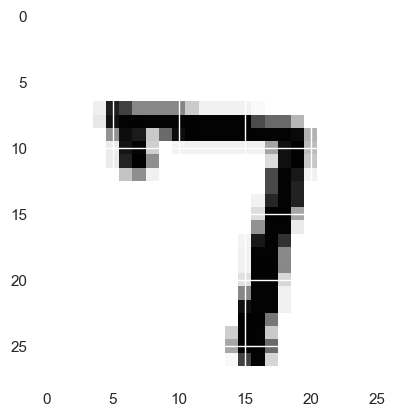

In [6]:
index = 900
label = train_data[1][index]
picture = train_data[0][index]

print("label: %i" % label)
plt.imshow(picture.reshape(28,28), cmap='Greys')

# Computation nodes

Instead of directly manipulating numpy arrays, we will manipulate abstraction that contains:
- a value (i.e. a numpy array)
- a bool indicating if we wish to compute the gradient with respect to the value
- the gradient with respect to the value
- the operation to call during backpropagation

There will be two kind of nodes:
- Tensor: a generic computation node
- Parameter: a computation node that is used to store parameters of the network. Parameters are always leaf nodes, i.e. they cannot be build from other computation nodes.

Our implementation of the backward pass will be really simple and incorrect in the general case (i.e. won't work with computation graph with loops).
We will just apply the derivative function for a given tensor and then call the ones of its antecedents, recursively.
This simple algorithm is good enough for this exercise.

Note that a real implementation of backprop will store temporary values during forward that can be used during backward to improve computation speed. We do not do that here.

In [7]:
class Tensor:
    def __init__(self, data, require_grad=False):
        # test type of data: should be np array
        if isinstance(data, float):
            data = np.array([data,])
        if type(data) != np.ndarray:
            raise RuntimeError("Input should be a numpy array")

        # store data for this tensor
        self.data = data
        self.require_grad = require_grad
        
        # this values should be set to enable autograd!
        self.gradient = None
        self.d = None
        self.backptr = None
        
    def zero_grad(self):
        """
        Set the gradient of thie tensor to 0
        """
        if self.require_grad:
            self.gradient = np.zeros_like(self.data)
            
    def accumulate_gradient(self, gradient):
        """
        Accumulte gradient for this tensor
        """
        if gradient.shape != self.data.shape:
            raise RuntimeError("Invalid gradient dimension")

        if self.gradient is None:
            self.gradient = np.copy(gradient)
        else:
            self.gradient += gradient
            
    def backward(self, g=None):
        """
        The backward pass!
        If g != None, then g is the gradient for the current node.
        i.e. g will be != None only for the loss output.
        
        You should call the function stored in self.d with correct arguments,
        and then recursively call the backward methods of tensors in the backptr list if:
        1. they require a gradient
        2. they are of type Tensor: check with isinstance(o, Tensor)
        """
        if not self.require_grad:  # stop right now if this node does not require a gradient
            return
        
        if g is not None:
            if isinstance(g, float):
                g = np.array([g])
            if type(g) != np.ndarray:
                raise RuntimeError("Gradient should be a numpy array")
            if g.shape != self.data.shape:
                raise RuntimeError("Gradient of different size than the value!")
                
            self.gradient = g

        

        if self.d is not None and self.backptr is not None:
            self.d(self.backptr, self.gradient)

            queue = self.backptr
            while len(queue) > 0:
                back_tensor = queue.pop(0)
                if isinstance(back_tensor, Tensor) and back_tensor.require_grad and back_tensor.d is not None and back_tensor.backptr is not None:                  
                    back_tensor.d(back_tensor.backptr, back_tensor.gradient)
                    queue.extend(back_tensor.backptr)
                
        
        
    
    
class Parameter(Tensor):
    """
    This class will be used to store parameters of the network only!
    """
    def __init__(self, data, name="unamed"):
        super().__init__(data, require_grad=True)
        self.name = name
        
    def backward(self):
        raise RuntimeError("You cannot backprop from a Parameter node")

# Functions

Functions manipulate tensors and build the required information for autograd.
A function returns a Tensor that should have require_grad = True if at least of the arguments require a gradient.

In [8]:
def any_require_grad(l):
    """
    Input:
    - l: an iterable (e.g. a list)
    Ouput:
    - True if any tensor in the input requires a gradient
    """
    return any(t.require_grad for t in l)

In [9]:
# Here is an exemple with the ReLU
def relu(x):
    v = np.maximum(0, x.data)
    
    output = Tensor(v, require_grad=x.require_grad)
    output.d = backward_relu
    output.backptr = [x]
    
    return output

def backward_relu(backptr, g):
    x, = backptr
    
    # the gradient is accumulated in the arguments only if required
    if x.require_grad:
        x.accumulate_gradient(g * (x.data > 0))

In [10]:
def tanh(x):
    v = np.tanh(x.data)
    
    output = Tensor(v, require_grad=x.require_grad)
    output.d = backward_tanh
    output.backptr = [x]
    
    return output

def backward_tanh(backptr, g):
    x, = backptr
    
    # the gradient is accumulated in the arguments only if required
    if x.require_grad:
        x.accumulate_gradient(g * (1 - np.tanh(x.data)**2))

Next, we implement the affine transform operation.
You can reuse the code from the first lab exercise, with one major difference: you have to compute the gradient with respect to x too!

In [11]:
def affine_transform(W, b, x):
    v = np.dot(W.data, x.data) + b.data
    
    output = Tensor(v, require_grad=any_require_grad([W, b, x]))
    output.d = backward_affine_transform
    output.backptr = [W, b, x]
    
    return output

def backward_affine_transform(backptr, g):
    W, b, x = backptr
    
    # the gradient is accumulated in the arguments only if required
    if W.require_grad:
        W.accumulate_gradient(np.outer(g, x.data))
    if b.require_grad:
        b.accumulate_gradient(g)
    if isinstance(x, Tensor) and x.require_grad:
        # (10, 100) (10,) (100,) (10,)
        #print(W.data.shape, b.data.shape, x.data.shape, g.shape)
        x.accumulate_gradient(np.dot(W.data.T, g))

In [12]:
# we use an underscore because this function does not manipulate tensors:
# it is exactly the same as in the previous exercise

def _softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / np.sum(exp_x)

def grad_softmax(x, gold):

    score = _softmax(x)
    score[gold] = score[gold] - 1 
    return score

def nll(x, gold):
    v =  -np.log(_softmax(x.data)[gold])

    output = Tensor(v, require_grad=x.require_grad)
    output.d = backward_nll
    output.backptr = [x, gold]

    return output

def backward_nll(backptr, g):
    # TODO
    x, gold = backptr
    g_x =  g * grad_softmax(x.data, gold)  
    
    if x.require_grad:
        x.accumulate_gradient(g_x)



# Module

Neural networks or parts of neural networks will be stored in Modules.
They implement method to retrieve all parameters of the network and subnetwork.

In [13]:
class Module:
    def __init__(self):
        raise NotImplemented("")
        
    def parameters(self):
        ret = []
        for name in dir(self):
            o = self.__getattribute__(name)

            if type(o) is Parameter:
                ret.append(o)
            if isinstance(o, Module) or isinstance(o, ModuleList):
                ret.extend(o.parameters())
        return ret

# if you want to store a list of Parameters or Module,
# you must store them in a ModuleList instead of a python list,
# in order to collect the parameters correctly
class ModuleList(list):
    def parameters(self):
        ret = []
        for m in self:
            if type(m) is Parameter:
                ret.append(m)
            elif isinstance(m, Module) or isinstance(m, ModuleList):
                ret.extend(m.parameters())
        return ret

# Initialization and optimization

In [14]:
def zero_init(b):
    b[:] = 0.

def glorot_init(W):
    W[:] = np.random.uniform(-np.sqrt(6. / (W.shape[0] + W.shape[1])), np.sqrt(6. / (W.shape[0] + W.shape[1])), W.shape)
    
# Look at slides for the formula!
def kaiming_init(W):
    W[:] = np.random.uniform(-np.sqrt(6. / (W.shape[1])), np.sqrt(6. / (W.shape[1])), W.shape)

In [15]:
# simple gradient descent optimizer
class SGD:
    def __init__(self, params, lr=0.1):
        self.params = params
        self.lr = lr
        
    def step(self):
        for p in self.params:
            p.data[:] = p.data - self.lr * p.gradient
        
    def zero_grad(self):
        for p in self.params:
            p.zero_grad()

# Networks and training loop

We first create a simple linear classifier, similar to the first lab exercise.

In [16]:
class LinearNetwork(Module):
    def __init__(self, dim_input, dim_output):
        # build the parameters
        self.W = Parameter(np.ndarray((dim_output, dim_input)), name="W")
        self.b = Parameter(np.ndarray((dim_output,)), name="b")
        
        self.init_parameters()
        
    def init_parameters(self):
        # init parameters of the network (i.e W and b)
        glorot_init(self.W.data)
        zero_init(self.b.data)
        
    def forward(self, x):
        return  affine_transform(self.W, self.b, x)

We will train several neural networks.
Therefore, we encapsulate the training loop in a function.

**warning**: you have to call optimizer.zero_grad() before each backward pass to reinitialize the gradient of the parameters!

In [17]:
class RunningLoss():
    def __init__(self):
        self.loss = 0.
        self.loss_history = []
        self.n = 0

    def update(self, loss):
        self.loss += loss
        self.loss_history.append(loss)
        self.n += 1

    def get(self):
        return self.loss / self.n

In [18]:
def training_loop(network, optimizer, train_data, dev_data, n_epochs=10):
    running_loss = RunningLoss()
    train_accs, dev_accs = [], []

    for epoch in range(n_epochs):
        print("Epoch %i" % (epoch + 1))

        shuffle = np.random.permutation(len(train_data[0]))
        shuffled_train_data = (train_data[0][shuffle], train_data[1][shuffle])

        # training loop
        pbar = tqdm(range(len(shuffled_train_data[0])), desc="Training", total=len(shuffled_train_data[0]), miniters=int(100))
        y_hats = []
        ys = []
        for i in pbar:
            x = shuffled_train_data[0][i]
            y = shuffled_train_data[1][i]

            optimizer.zero_grad()
            # forward
            y_hat = network.forward(x)
            loss = nll(y_hat, y)
            # backward
            loss.backward(g=1.0)
            # update
            optimizer.step()

            # Update the running loss
            running_loss.update(loss.data[0])
            if i%100 == 0:
                pbar.set_postfix(loss=running_loss.get())

            # Store the output of the network
            y_hats.append(y_hat.data)
            ys.append(y)

        # evaluation on train
        y_hats = []
        ys = []
        # evaluation on dev
        for i in range(len(train_data[0])):
            x = train_data[0][i]
            y = train_data[1][i]
            y_hat = network.forward(x)
            y_hats.append(y_hat.data)
            ys.append(y)
        train_acc = np.mean(np.argmax(y_hats, axis=1) == ys)
        print("Train accuracy: %.2f" % (train_acc * 100))
        train_accs.append(train_acc)

        y_hats = []
        ys = []
        # evaluation on dev
        for i in range(len(dev_data[0])):
            x = dev_data[0][i]
            y = dev_data[1][i]
            y_hat = network.forward(x)
            y_hats.append(y_hat.data)
            ys.append(y)
        dev_acc = np.mean(np.argmax(y_hats, axis=1) == ys)
        print("Dev accuracy: %.2f" % (dev_acc * 100))
        dev_accs.append(dev_acc)
    return running_loss, train_accs, dev_accs
            


In [485]:
dim_input = 28*28
dim_output = 10

network = LinearNetwork(dim_input, dim_output)
optimizer = SGD(network.parameters(), 0.01)

running_loss, train_accs, dev_accs = training_loop(network, optimizer, train_data, dev_data, n_epochs=5)

Epoch 1


Training: 100%|██████████| 50000/50000 [00:02<00:00, 16679.18it/s, loss=0.379]


Train accuracy: 91.14
Dev accuracy: 91.66
Epoch 2


Training: 100%|██████████| 50000/50000 [00:02<00:00, 17347.89it/s, loss=0.344]


Train accuracy: 91.92
Dev accuracy: 92.05
Epoch 3


Training: 100%|██████████| 50000/50000 [00:03<00:00, 15965.02it/s, loss=0.329]


Train accuracy: 92.34
Dev accuracy: 92.57
Epoch 4


Training: 100%|██████████| 50000/50000 [00:03<00:00, 15371.42it/s, loss=0.319]


Train accuracy: 92.04
Dev accuracy: 92.29
Epoch 5


Training: 100%|██████████| 50000/50000 [00:03<00:00, 16330.45it/s, loss=0.313]


Train accuracy: 92.41
Dev accuracy: 92.26


After you finished the linear network, you can move to a deep network!

In [486]:
class DeepNetwork(Module):
    def __init__(self, dim_input, dim_output, hidden_dim, n_layers, tanh=False):
        assert n_layers > 1
        self.W = ModuleList()
        self.b = ModuleList()
        self.tanh = tanh
        
        # TODO...
        for i in range(n_layers-1):
            _dim_input = hidden_dim
            _dim_output = hidden_dim
            if i == 0:
                _dim_input = dim_input
            self.W.append(Parameter(np.ndarray((_dim_output, _dim_input)), name="W_%i" % i))
            self.b.append(Parameter(np.ndarray((_dim_output,)), name="b_%i" % i))
        
        self.output_proj = Parameter(np.ndarray((dim_output, hidden_dim)), name="output_proj")
        self.output_bias = Parameter(np.ndarray((dim_output,)), name="output_bias")
        
        self.init_parameters()
        
    def init_parameters(self):
        # TODO
        for i in range(len(self.W)):
            glorot_init(self.W[i].data)
            zero_init(self.b[i].data)
        glorot_init(self.output_proj.data)
        zero_init(self.output_bias.data)

    def forward(self, x):
        # TODO
        for i in range(len(self.W)):
            x = affine_transform(self.W[i], self.b[i], x)
            if self.tanh:
                x = tanh(x)
            else:
                x = relu(x)
        x = affine_transform(self.output_proj, self.output_bias, x)
        return x

In [487]:
dim_input = 28*28
dim_output = 10

network = DeepNetwork(dim_input, dim_output, 100, 2)
optimizer = SGD(network.parameters(), 0.01)

running_loss, train_accs, dev_accs = training_loop(network, optimizer, train_data, dev_data, n_epochs=5)

Epoch 1


Training: 100%|██████████| 50000/50000 [00:45<00:00, 1095.45it/s, loss=0.241]


Train accuracy: 96.87
Dev accuracy: 96.70
Epoch 2


Training: 100%|██████████| 50000/50000 [00:46<00:00, 1075.05it/s, loss=0.176]


Train accuracy: 97.23
Dev accuracy: 96.52
Epoch 3


Training: 100%|██████████| 50000/50000 [00:44<00:00, 1115.52it/s, loss=0.144]


Train accuracy: 98.17
Dev accuracy: 96.92
Epoch 4


Training: 100%|██████████| 50000/50000 [01:23<00:00, 601.64it/s, loss=0.124] 


Train accuracy: 98.34
Dev accuracy: 97.10
Epoch 5


Training: 100%|██████████| 50000/50000 [00:54<00:00, 916.64it/s, loss=0.109] 


Train accuracy: 98.63
Dev accuracy: 97.05


## with tanh=True

In [488]:
dim_input = 28*28
dim_output = 10

network = DeepNetwork(dim_input, dim_output, 100, 2, tanh=True)
optimizer = SGD(network.parameters(), 0.01)

running_loss, train_accs, dev_accs = training_loop(network, optimizer, train_data, dev_data, n_epochs=5)

Epoch 1


Training: 100%|██████████| 50000/50000 [00:45<00:00, 1106.63it/s, loss=0.269]


Train accuracy: 95.64
Dev accuracy: 95.47
Epoch 2


Training: 100%|██████████| 50000/50000 [00:42<00:00, 1167.98it/s, loss=0.199]


Train accuracy: 97.40
Dev accuracy: 96.83
Epoch 3


Training: 100%|██████████| 50000/50000 [00:46<00:00, 1069.40it/s, loss=0.163]


Train accuracy: 97.80
Dev accuracy: 96.88
Epoch 4


Training: 100%|██████████| 50000/50000 [00:44<00:00, 1111.26it/s, loss=0.139]


Train accuracy: 98.44
Dev accuracy: 97.18
Epoch 5


Training: 100%|██████████| 50000/50000 [00:46<00:00, 1079.50it/s, loss=0.122]


Train accuracy: 98.91
Dev accuracy: 97.24


## Bonus

You can try to implement a momentum SGD optimizer! Note that you have to keep track of the velocity for each parameter in the optimizer.


In [489]:
class MomentumSGD:
    def __init__(self, params, lr=0.1, momentum=0.9):
        self.params = params
        self.lr = lr
        self.momentum = momentum
        self.velocities = [np.zeros_like(p.data) for p in self.params]
        
    def step(self):
        for i, p in enumerate(self.params):
            v = self.velocities[i]
            v[:] = self.momentum * v + (1 - self.momentum) * p.gradient
            p.data[:] = p.data - self.lr * v
        
    def zero_grad(self):
        for p in self.params:
            p.zero_grad()

In [490]:
dim_input = 28*28
dim_output = 10

network = DeepNetwork(dim_input, dim_output, 100, 2)
optimizer = MomentumSGD(network.parameters(), 0.01, momentum=0.9)

running_loss, train_accs, dev_accs = training_loop(network, optimizer, train_data, dev_data, n_epochs=5)

Epoch 1


Training: 100%|██████████| 50000/50000 [00:53<00:00, 942.33it/s, loss=0.238] 


Train accuracy: 96.58
Dev accuracy: 96.33
Epoch 2


Training: 100%|██████████| 50000/50000 [01:06<00:00, 750.17it/s, loss=0.175] 


Train accuracy: 97.78
Dev accuracy: 97.08
Epoch 3


Training: 100%|██████████| 50000/50000 [00:58<00:00, 858.17it/s, loss=0.143] 


Train accuracy: 98.11
Dev accuracy: 97.03
Epoch 4


Training: 100%|██████████| 50000/50000 [01:12<00:00, 689.52it/s, loss=0.123] 


Train accuracy: 98.51
Dev accuracy: 97.42
Epoch 5


Training: 100%|██████████| 50000/50000 [01:05<00:00, 769.22it/s, loss=0.108] 


Train accuracy: 98.75
Dev accuracy: 97.45


# Bonus: Improvements

Here we added the following improvements on top of the original code:
- A hyperparameters grid search for the best hyperparameters
- Learning rate scheduler
- Mini Batch Gradient Descent instead of Stochastic Gradient Descent
- Adam optimizer instead of MomentumSGD
- A plot of loss and accuracy over time

In [19]:
def affine_transform_batch(W, b, x):
    v = np.dot(x.data, W.data) + b.data
    
    output = Tensor(v, require_grad=any_require_grad([W, b, x]))
    output.d = backward_affine_transform_batch
    output.backptr = [W, b, x]
    
    return output

def backward_affine_transform_batch(backptr, g):
    W, b, x = backptr
    
    # the gradient is accumulated in the arguments only if required
    if W.require_grad:
        W.accumulate_gradient(np.dot(np.array(x.data).T, g))
    if b.require_grad:
        b.accumulate_gradient(np.sum(g, axis=0).reshape(b.data.shape))
    if isinstance(x, Tensor) and x.require_grad:
        # (10, 100) (10,) (100,) (10,)
        #print(W.data.shape, b.data.shape, x.data.shape, g.shape)
        x.accumulate_gradient(np.dot(g, W.data.T))

In [20]:
# we use an underscore because this function does not manipulate tensors:
# it is exactly the same as in the previous exercise

def _softmax_batch(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True)) + 1e-8
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def grad_softmax_batch(x, gold):

    score = _softmax_batch(x)
    score[np.arange(len(gold)), gold] -= 1
    return score

def nll_batch(x, gold):
    v =  -np.log(_softmax_batch(x.data)[np.arange(len(gold)), gold]).mean()

    output = Tensor(v, require_grad=x.require_grad)
    output.d = backward_nll_batch
    output.backptr = [x, gold]

    return output

def backward_nll_batch(backptr, g):
    # TODO
    x, gold = backptr
    g_x =  g * grad_softmax_batch(x.data, gold)
    
    if x.require_grad:
        x.accumulate_gradient(g_x)



In [21]:
class DeepNetworkBatch(Module):
    def __init__(self, dim_input, dim_output, hidden_dims, tanh=False):
        self.W = ModuleList()
        self.b = ModuleList()
        self.tanh = tanh
        
        # TODO...
        for i in range(len(hidden_dims)-1):
            _dim_input = hidden_dims[i]
            _dim_output = hidden_dims[i+1]
            if i == 0:
                _dim_input = dim_input
            self.W.append(Parameter(np.ndarray((_dim_input, _dim_output)), name="W_%i" % i))
            self.b.append(Parameter(np.ndarray((1, _dim_output)), name="b_%i" % i))
        
        self.output_proj = Parameter(np.ndarray((hidden_dims[-1], dim_output)), name="output_proj")
        self.output_bias = Parameter(np.ndarray((1, dim_output)), name="output_bias")
        
        self.init_parameters()
        
    def init_parameters(self):
        # TODO
        for i in range(len(self.W)):
            glorot_init(self.W[i].data)
            zero_init(self.b[i].data)
        glorot_init(self.output_proj.data)
        zero_init(self.output_bias.data)

    def forward(self, x):
        # TODO
        for i in range(len(self.W)):
            x = affine_transform_batch(self.W[i], self.b[i], x)
            if self.tanh:
                x = tanh(x)
            else:
                x = relu(x)
        x = affine_transform_batch(self.output_proj, self.output_bias, x)
        return x

In [22]:
class Adam:
    def __init__(self, params, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8, lr_scheduler=None, max_iter=None):
        self.params = params
        self.lr = lr
        self.current_lr = lr
        self.lr_scheduler = lr_scheduler
        self.max_iter = max_iter
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.m = [np.zeros_like(p.data) for p in self.params]
        self.v = [np.zeros_like(p.data) for p in self.params]
        self.t = 0
        
    def step(self):
        self.t += 1
        for i, p in enumerate(self.params):
            if self.lr_scheduler == 'cosine' and self.max_iter is not None:
                self.current_lr = self.lr * 0.5 * (1 + np.cos(np.pi * self.t / self.max_iter))

            m = self.m[i]
            v = self.v[i]
            m[:] = self.beta1 * m + (1 - self.beta1) * p.gradient
            v[:] = self.beta2 * v + (1 - self.beta2) * p.gradient**2
            m_hat = m / (1 - self.beta1**self.t)
            v_hat = v / (1 - self.beta2**self.t)
            p.data[:] = p.data - self.current_lr * m_hat / (np.sqrt(v_hat) + self.eps)
        
    def zero_grad(self):
        for p in self.params:
            p.zero_grad()

In [23]:
def training_loop_batch(network, optimizer, train_data, dev_data, n_epochs=10, batch_size=32, patience_threshold=5):
    running_loss = RunningLoss()
    train_accs, dev_accs = [], []
    best_W = None
    best_b = None
    best_dev_acc = 0
    patience = 0

    for epoch in range(n_epochs):
        print("Epoch %i" % (epoch + 1))

        shuffle = np.random.permutation(len(train_data[0]))
        shuffled_train_data = (train_data[0][shuffle], train_data[1][shuffle])

        # training loop
        len_train = len(shuffled_train_data[0])//batch_size + (1 if len(shuffled_train_data[0])%batch_size>0 else 0)
        pbar = tqdm(range(len_train), desc="Training", total=len_train, miniters=int(100))
        y_hats = []
        ys = []

        for i in pbar:
            x = shuffled_train_data[0][i:i+batch_size]
            y = shuffled_train_data[1][i:i+batch_size]

            optimizer.zero_grad()
            # forward
            y_hat = network.forward(x)
            loss = nll_batch(y_hat, y)
            # backward
            loss.backward(g=1.0)
            # update
            optimizer.step()

            # Update the running loss
            # print(loss.data)
            running_loss.update(loss.data[0])
            if i%100 == 0:
                pbar.set_postfix(loss=running_loss.get())

            # Store the output of the network
            y_hats.append(y_hat.data)
            ys.append(y)

        # evaluation on train
        y_hats = []
        ys = []
        for i in range(len_train):
            x = train_data[0][i:i+batch_size]
            y = train_data[1][i:i+batch_size]
            y_hat = network.forward(x)
            y_hats.append(y_hat.data)
            ys.append(y)
        y_hats = np.concatenate(y_hats, axis=0)
        ys = np.concatenate(ys, axis=0)
        train_acc = np.mean(np.argmax(y_hats, axis=1) == ys)
        print("Train accuracy: %.2f" % (train_acc * 100))
        train_accs.append(train_acc)

        len_dev = len(dev_data[0])//batch_size + (1 if len(dev_data[0])%batch_size>0 else 0)
        y_hats = []
        ys = []
        # evaluation on dev
        for i in range(len_dev):
            x = dev_data[0][i:i+batch_size]
            y = dev_data[1][i:i+batch_size]
            y_hat = network.forward(x)
            y_hats.append(y_hat.data)
            ys.append(y)
        y_hats = np.concatenate(y_hats, axis=0)
        ys = np.concatenate(ys, axis=0)
        dev_acc = np.mean(np.argmax(y_hats, axis=1) == ys)
        print("Dev accuracy: %.2f" % (dev_acc * 100))
        dev_accs.append(dev_acc)

        if dev_accs[-1] > best_dev_acc:
            best_W = network.W 
            best_b = network.b 
            best_dev_acc = dev_accs[-1]
            patience = 0
        else: 
            patience+=1 

        if patience > patience_threshold:
            # Break the loop
            print("Dev accuracy not improving for %i epochs. Stopping." % patience_threshold)
            break
    return running_loss, train_accs, dev_accs, best_W, best_b, best_dev_acc

In [24]:
def evaluate_dataset(W, b, data, gold):
    predictions = predict(W, b, data)
    return accuracy_score(gold, predictions)

def split_in_batches(images, labels, batch_size): 
    batch_images = np.array_split(images, len(images) // batch_size) 
    batch_labels = np.array_split(labels, len(labels) // batch_size)

    return batch_images, batch_labels

def shuffled_data(data):
    perm = np.random.permutation(len(data[0])) 
    return data[0][perm], data[1][perm].astype(np.int32) 

def predict(W, b, x):
    return np.argmax(affine_transform_batch(W, b, x), axis=1)

In [26]:
grid_params = {
    'lr': [0.01, 0.001, 0.0001],
    'n_epochs': [5, 10, 20],
    'batch_size': [4,16,64],
    'lr_scheduler': ['cosine', None],
    'patience_threshold': [3]
}

In [27]:
import gc 
import pandas as pd
import pickle 
import time 
df = pd.DataFrame(columns=['lr', 'n_epochs', 'do_shuffle', 'decay', 'patience_threshold', 'train_accuracy', 'dev_accuracy', 'best_dev_accuracy', 'time'])

In [499]:
experiment_no = 0
dim_input = 28*28
dim_output = 10

best_dev_acc_overall = 0
best_params = None

for lr in grid_params['lr']:
    for n_epochs in grid_params['n_epochs']:
        for batch_size in grid_params['batch_size']:
            for lr_scheduler in grid_params['lr_scheduler']:
                for patience_threshold in grid_params['patience_threshold']:

                    gc.collect()
                    start = time.time()

                    max_iter = n_epochs*len(train_data[0])//batch_size

                    print('*'*100)
                    print(f'Running with lr: {lr}, n_epochs: {n_epochs}, batch_size: {batch_size}, lr_scheduler: {lr_scheduler if lr_scheduler is not None else "no scheduler"}, patience_threshold: {patience_threshold}')


                    network = DeepNetworkBatch(dim_input, dim_output, hidden_dims = [100, 50, 20])
                    optimizer = Adam(network.parameters(), lr=lr, lr_scheduler=lr_scheduler, max_iter=max_iter)

                    running_loss, train_accs, dev_accs, best_W, best_b, best_dev_acc = training_loop_batch(network, optimizer, train_data, dev_data, n_epochs=n_epochs, batch_size=batch_size, patience_threshold=patience_threshold)

                    end = time.time()

                    df = df.append({
                        'lr': lr,
                        'n_epochs': n_epochs,
                        'batch_size': batch_size,
                        'lr_scheduler': lr_scheduler,
                        'patience_threshold': patience_threshold,
                        'train_accuracy': train_accs[-1],
                        'dev_accuracy': dev_accs[-1],
                        'best_dev_accuracy': best_dev_acc, 
                        'time': end-start
                    } , ignore_index=True)

                    df.to_csv('experiment.csv', index=False)

                    pickle_json = {
                        'W': best_W,
                        'b': best_b,
                        'train_accuracy': train_accs,
                        'dev_accuracy': dev_accs,
                        'loss_list': running_loss.loss_history,
                        'best_dev_accuracy': best_dev_acc
                    }

                    with open(f'./experiment_{experiment_no}.pkl', 'wb') as f:
                        pickle.dump(pickle_json, f)

                    experiment_no += 1

                    if best_dev_acc > best_dev_acc_overall:
                        best_dev_acc_overall = best_dev_acc
                        print(f'New best dev accuracy: {best_dev_acc_overall}')
                        best_params = {
                            'lr': lr,
                            'n_epochs': n_epochs,
                            'batch_size': batch_size,
                            'lr_scheduler': lr_scheduler,
                            'patience_threshold': patience_threshold,
                            'best_W': best_W,
                            'best_b': best_b,
                            'loss_list': running_loss.loss_history,
                            'train_accs': train_accs,
                            'dev_accs': dev_accs
                        }

****************************************************************************************************
Running with lr: 0.01, n_epochs: 5, batch_size: 4, lr_scheduler: cosine, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2656.28it/s, loss=0.859]


Train accuracy: 75.12
Dev accuracy: 75.56
Epoch 2


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2776.89it/s, loss=0.805]


Train accuracy: 79.12
Dev accuracy: 80.41
Epoch 3


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2653.05it/s, loss=0.786]


Train accuracy: 72.45
Dev accuracy: 72.45
Epoch 4


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2605.82it/s, loss=0.753]


Train accuracy: 82.72
Dev accuracy: 82.61
Epoch 5


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2587.45it/s, loss=0.712]


Train accuracy: 83.58
Dev accuracy: 83.73
New best dev accuracy: 0.8373


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.01, n_epochs: 5, batch_size: 4, lr_scheduler: no scheduler, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2721.30it/s, loss=1.03]


Train accuracy: 70.53
Dev accuracy: 71.45
Epoch 2


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2807.71it/s, loss=1.01] 


Train accuracy: 50.80
Dev accuracy: 50.09
Epoch 3


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2776.05it/s, loss=1.09]


Train accuracy: 42.82
Dev accuracy: 44.45
Epoch 4


Training: 100%|██████████| 12500/12500 [00:05<00:00, 2415.47it/s, loss=1.17]


Train accuracy: 32.73
Dev accuracy: 33.94
Epoch 5


Training: 100%|██████████| 12500/12500 [00:05<00:00, 2494.81it/s, loss=1.22]


Train accuracy: 35.56
Dev accuracy: 36.78
Dev accuracy not improving for 3 epochs. Stopping.


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.01, n_epochs: 5, batch_size: 16, lr_scheduler: cosine, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 3125/3125 [00:12<00:00, 257.61it/s, loss=0.433]


Train accuracy: 73.84
Dev accuracy: 75.91
Epoch 2


Training: 100%|██████████| 3125/3125 [00:11<00:00, 269.17it/s, loss=0.47] 


Train accuracy: 78.16
Dev accuracy: 82.99
Epoch 3


Training: 100%|██████████| 3125/3125 [00:06<00:00, 513.00it/s, loss=0.45] 


Train accuracy: 85.67
Dev accuracy: 87.63
Epoch 4


Training: 100%|██████████| 3125/3125 [00:06<00:00, 506.73it/s, loss=0.443]


Train accuracy: 86.28
Dev accuracy: 88.38
Epoch 5


Training: 100%|██████████| 3125/3125 [00:04<00:00, 711.88it/s, loss=0.442]


Train accuracy: 88.02
Dev accuracy: 89.50
New best dev accuracy: 0.895


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.01, n_epochs: 5, batch_size: 16, lr_scheduler: no scheduler, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 3125/3125 [00:05<00:00, 558.68it/s, loss=0.369]


Train accuracy: 76.32
Dev accuracy: 79.68
Epoch 2


Training: 100%|██████████| 3125/3125 [00:05<00:00, 617.02it/s, loss=0.464]


Train accuracy: 73.12
Dev accuracy: 76.03
Epoch 3


Training: 100%|██████████| 3125/3125 [00:05<00:00, 537.31it/s, loss=0.509]


Train accuracy: 76.20
Dev accuracy: 79.86
Epoch 4


Training: 100%|██████████| 3125/3125 [00:06<00:00, 473.50it/s, loss=0.527]


Train accuracy: 77.39
Dev accuracy: 82.40
Epoch 5


Training: 100%|██████████| 3125/3125 [00:06<00:00, 497.40it/s, loss=0.543]


Train accuracy: 80.67
Dev accuracy: 82.94


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.01, n_epochs: 5, batch_size: 64, lr_scheduler: cosine, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 782/782 [00:01<00:00, 435.93it/s, loss=0.0812]


Train accuracy: 76.85
Dev accuracy: 79.27
Epoch 2


Training: 100%|██████████| 782/782 [00:01<00:00, 423.53it/s, loss=0.0728]


Train accuracy: 78.97
Dev accuracy: 85.01
Epoch 3


Training: 100%|██████████| 782/782 [00:01<00:00, 497.98it/s, loss=0.0798]


Train accuracy: 84.10
Dev accuracy: 87.80
Epoch 4


Training: 100%|██████████| 782/782 [00:01<00:00, 456.53it/s, loss=0.0829]


Train accuracy: 88.04
Dev accuracy: 92.83
Epoch 5


Training: 100%|██████████| 782/782 [00:01<00:00, 478.80it/s, loss=0.123] 


Train accuracy: 88.58
Dev accuracy: 93.73
New best dev accuracy: 0.9373009554140127


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.01, n_epochs: 5, batch_size: 64, lr_scheduler: no scheduler, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 782/782 [00:01<00:00, 395.00it/s, loss=0.088] 


Train accuracy: 79.52
Dev accuracy: 84.61
Epoch 2


Training: 100%|██████████| 782/782 [00:01<00:00, 463.18it/s, loss=0.0731]


Train accuracy: 78.79
Dev accuracy: 85.80
Epoch 3


Training: 100%|██████████| 782/782 [00:01<00:00, 462.52it/s, loss=0.0768]


Train accuracy: 79.22
Dev accuracy: 86.53
Epoch 4


Training: 100%|██████████| 782/782 [00:01<00:00, 462.75it/s, loss=0.0755]


Train accuracy: 83.37
Dev accuracy: 88.98
Epoch 5


Training: 100%|██████████| 782/782 [00:01<00:00, 444.57it/s, loss=0.0856]


Train accuracy: 77.84
Dev accuracy: 81.72
****************************************************************************************************
Running with lr: 0.01, n_epochs: 10, batch_size: 4, lr_scheduler: cosine, patience_threshold: 3
Epoch 1


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
Training: 100%|██████████| 12500/12500 [00:04<00:00, 2540.71it/s, loss=1.03]


Train accuracy: 70.77
Dev accuracy: 70.69
Epoch 2


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2642.06it/s, loss=1.04]


Train accuracy: 59.26
Dev accuracy: 61.02
Epoch 3


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2685.69it/s, loss=1.06]


Train accuracy: 58.08
Dev accuracy: 58.70
Epoch 4


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2567.67it/s, loss=1.05]


Train accuracy: 66.18
Dev accuracy: 65.74
Epoch 5


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2621.43it/s, loss=1.03]


Train accuracy: 58.69
Dev accuracy: 59.52
Dev accuracy not improving for 3 epochs. Stopping.


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.01, n_epochs: 10, batch_size: 4, lr_scheduler: no scheduler, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 12500/12500 [00:05<00:00, 2449.40it/s, loss=1.06]


Train accuracy: 63.85
Dev accuracy: 64.40
Epoch 2


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2595.30it/s, loss=1.08]


Train accuracy: 50.24
Dev accuracy: 51.42
Epoch 3


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2551.24it/s, loss=1.18]


Train accuracy: 43.58
Dev accuracy: 45.67
Epoch 4


Training: 100%|██████████| 12500/12500 [00:05<00:00, 2226.71it/s, loss=1.28]


Train accuracy: 28.02
Dev accuracy: 29.29
Epoch 5


Training: 100%|██████████| 12500/12500 [00:05<00:00, 2489.75it/s, loss=1.32]


Train accuracy: 43.77
Dev accuracy: 46.07
Dev accuracy not improving for 3 epochs. Stopping.


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.01, n_epochs: 10, batch_size: 16, lr_scheduler: cosine, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 3125/3125 [00:09<00:00, 347.01it/s, loss=0.456]


Train accuracy: 72.79
Dev accuracy: 76.45
Epoch 2


Training: 100%|██████████| 3125/3125 [00:07<00:00, 433.05it/s, loss=0.484]


Train accuracy: 82.29
Dev accuracy: 84.22
Epoch 3


Training: 100%|██████████| 3125/3125 [00:09<00:00, 334.09it/s, loss=0.476]


Train accuracy: 74.61
Dev accuracy: 78.92
Epoch 4


Training: 100%|██████████| 3125/3125 [00:09<00:00, 343.70it/s, loss=0.475]


Train accuracy: 87.16
Dev accuracy: 88.24
Epoch 5


Training: 100%|██████████| 3125/3125 [00:08<00:00, 355.05it/s, loss=0.472]


Train accuracy: 87.46
Dev accuracy: 88.43
Epoch 6


Training: 100%|██████████| 3125/3125 [00:08<00:00, 350.45it/s, loss=0.458]


Train accuracy: 84.95
Dev accuracy: 86.86
Epoch 7


Training: 100%|██████████| 3125/3125 [00:09<00:00, 330.80it/s, loss=0.446]


Train accuracy: 89.12
Dev accuracy: 88.27
Epoch 8


Training: 100%|██████████| 3125/3125 [00:08<00:00, 353.03it/s, loss=0.431]


Train accuracy: 90.87
Dev accuracy: 91.15
Epoch 9


Training: 100%|██████████| 3125/3125 [00:06<00:00, 466.42it/s, loss=0.419]


Train accuracy: 90.91
Dev accuracy: 91.18
Epoch 10


Training: 100%|██████████| 3125/3125 [00:08<00:00, 356.86it/s, loss=0.417]


Train accuracy: 91.10
Dev accuracy: 91.47


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.01, n_epochs: 10, batch_size: 16, lr_scheduler: no scheduler, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 3125/3125 [00:07<00:00, 419.89it/s, loss=0.428]


Train accuracy: 74.55
Dev accuracy: 76.08
Epoch 2


Training: 100%|██████████| 3125/3125 [00:10<00:00, 291.12it/s, loss=0.477]


Train accuracy: 69.53
Dev accuracy: 71.57
Epoch 3


Training: 100%|██████████| 3125/3125 [00:07<00:00, 411.16it/s, loss=0.512]


Train accuracy: 75.30
Dev accuracy: 79.45
Epoch 4


Training: 100%|██████████| 3125/3125 [00:07<00:00, 440.16it/s, loss=0.532]


Train accuracy: 79.47
Dev accuracy: 81.75
Epoch 5


Training: 100%|██████████| 3125/3125 [00:07<00:00, 412.37it/s, loss=0.542]


Train accuracy: 70.24
Dev accuracy: 71.60
Epoch 6


Training: 100%|██████████| 3125/3125 [00:07<00:00, 431.67it/s, loss=0.539]


Train accuracy: 70.65
Dev accuracy: 73.32
Epoch 7


Training: 100%|██████████| 3125/3125 [00:07<00:00, 412.39it/s, loss=0.559]


Train accuracy: 75.97
Dev accuracy: 75.46
Epoch 8


Training: 100%|██████████| 3125/3125 [00:08<00:00, 378.92it/s, loss=0.58] 


Train accuracy: 65.48
Dev accuracy: 66.70
Dev accuracy not improving for 3 epochs. Stopping.


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.01, n_epochs: 10, batch_size: 64, lr_scheduler: cosine, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 782/782 [00:02<00:00, 305.84it/s, loss=0.0728]


Train accuracy: 84.00
Dev accuracy: 85.70
Epoch 2


Training: 100%|██████████| 782/782 [00:02<00:00, 347.86it/s, loss=0.0642]


Train accuracy: 76.50
Dev accuracy: 84.33
Epoch 3


Training: 100%|██████████| 782/782 [00:02<00:00, 299.77it/s, loss=0.0719]


Train accuracy: 79.22
Dev accuracy: 88.20
Epoch 4


Training: 100%|██████████| 782/782 [00:02<00:00, 284.89it/s, loss=0.0792]


Train accuracy: 79.02
Dev accuracy: 84.03
Epoch 5


Training: 100%|██████████| 782/782 [00:03<00:00, 218.13it/s, loss=0.0858]


Train accuracy: 80.35
Dev accuracy: 86.40
Epoch 6


Training: 100%|██████████| 782/782 [00:03<00:00, 249.82it/s, loss=0.0928]


Train accuracy: 80.56
Dev accuracy: 88.61
Epoch 7


Training: 100%|██████████| 782/782 [00:02<00:00, 269.00it/s, loss=0.0966]


Train accuracy: 88.61
Dev accuracy: 90.60
Epoch 8


Training: 100%|██████████| 782/782 [00:02<00:00, 390.04it/s, loss=0.101] 


Train accuracy: 88.94
Dev accuracy: 91.99
Epoch 9


Training: 100%|██████████| 782/782 [00:03<00:00, 249.81it/s, loss=0.108]


Train accuracy: 88.37
Dev accuracy: 90.47
Epoch 10


Training: 100%|██████████| 782/782 [00:02<00:00, 359.27it/s, loss=0.128]


Train accuracy: 89.75
Dev accuracy: 93.94
New best dev accuracy: 0.939390923566879


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.01, n_epochs: 10, batch_size: 64, lr_scheduler: no scheduler, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 782/782 [00:02<00:00, 304.15it/s, loss=0.0784]


Train accuracy: 81.91
Dev accuracy: 84.39
Epoch 2


Training: 100%|██████████| 782/782 [00:02<00:00, 327.52it/s, loss=0.0752]


Train accuracy: 78.10
Dev accuracy: 81.63
Epoch 3


Training: 100%|██████████| 782/782 [00:02<00:00, 274.60it/s, loss=0.0772]


Train accuracy: 82.63
Dev accuracy: 84.71
Epoch 4


Training: 100%|██████████| 782/782 [00:02<00:00, 353.54it/s, loss=0.0876]


Train accuracy: 83.03
Dev accuracy: 90.60
Epoch 5


Training: 100%|██████████| 782/782 [00:02<00:00, 267.31it/s, loss=0.0924]


Train accuracy: 83.47
Dev accuracy: 86.40
Epoch 6


Training: 100%|██████████| 782/782 [00:01<00:00, 425.49it/s, loss=0.1]   


Train accuracy: 79.81
Dev accuracy: 82.00
Epoch 7


Training: 100%|██████████| 782/782 [00:02<00:00, 307.21it/s, loss=0.111]


Train accuracy: 82.16
Dev accuracy: 88.67
Epoch 8


Training: 100%|██████████| 782/782 [00:02<00:00, 329.18it/s, loss=0.118]


Train accuracy: 83.54
Dev accuracy: 83.10
Dev accuracy not improving for 3 epochs. Stopping.


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.01, n_epochs: 20, batch_size: 4, lr_scheduler: cosine, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 12500/12500 [00:05<00:00, 2425.57it/s, loss=1.48]


Train accuracy: 60.19
Dev accuracy: 61.40
Epoch 2


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2636.02it/s, loss=1.39]


Train accuracy: 50.41
Dev accuracy: 52.51
Epoch 3


Training: 100%|██████████| 12500/12500 [00:05<00:00, 2474.18it/s, loss=1.39]


Train accuracy: 40.85
Dev accuracy: 41.44
Epoch 4


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2743.89it/s, loss=1.38]


Train accuracy: 43.76
Dev accuracy: 45.31
Epoch 5


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2608.19it/s, loss=1.39]


Train accuracy: 37.02
Dev accuracy: 38.52
Dev accuracy not improving for 3 epochs. Stopping.


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.01, n_epochs: 20, batch_size: 4, lr_scheduler: no scheduler, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 12500/12500 [00:05<00:00, 2457.03it/s, loss=1.2] 


Train accuracy: 57.97
Dev accuracy: 59.17
Epoch 2


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2525.51it/s, loss=1.24]


Train accuracy: 38.57
Dev accuracy: 38.33
Epoch 3


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2519.34it/s, loss=1.35]


Train accuracy: 28.02
Dev accuracy: 28.24
Epoch 4


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2626.76it/s, loss=1.43]


Train accuracy: 17.34
Dev accuracy: 17.95
Epoch 5


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2653.90it/s, loss=1.53]


Train accuracy: 20.89
Dev accuracy: 19.76
Dev accuracy not improving for 3 epochs. Stopping.


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.01, n_epochs: 20, batch_size: 16, lr_scheduler: cosine, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 3125/3125 [00:07<00:00, 444.20it/s, loss=0.429]


Train accuracy: 79.03
Dev accuracy: 84.75
Epoch 2


Training: 100%|██████████| 3125/3125 [00:06<00:00, 487.97it/s, loss=0.441]


Train accuracy: 76.33
Dev accuracy: 77.04
Epoch 3


Training: 100%|██████████| 3125/3125 [00:07<00:00, 431.97it/s, loss=0.488]


Train accuracy: 80.21
Dev accuracy: 84.26
Epoch 4


Training: 100%|██████████| 3125/3125 [00:06<00:00, 513.47it/s, loss=0.511]


Train accuracy: 74.77
Dev accuracy: 76.76
Epoch 5


Training: 100%|██████████| 3125/3125 [00:06<00:00, 458.57it/s, loss=0.513]


Train accuracy: 70.77
Dev accuracy: 75.34
Dev accuracy not improving for 3 epochs. Stopping.


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.01, n_epochs: 20, batch_size: 16, lr_scheduler: no scheduler, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 3125/3125 [00:06<00:00, 462.34it/s, loss=0.576]


Train accuracy: 76.83
Dev accuracy: 80.88
Epoch 2


Training: 100%|██████████| 3125/3125 [00:07<00:00, 444.10it/s, loss=0.561]


Train accuracy: 79.91
Dev accuracy: 82.13
Epoch 3


Training: 100%|██████████| 3125/3125 [00:07<00:00, 394.38it/s, loss=0.569]


Train accuracy: 79.86
Dev accuracy: 82.13
Epoch 4


Training: 100%|██████████| 3125/3125 [00:06<00:00, 465.15it/s, loss=0.582]


Train accuracy: 66.55
Dev accuracy: 70.18
Epoch 5


Training: 100%|██████████| 3125/3125 [00:06<00:00, 484.36it/s, loss=0.592]


Train accuracy: 78.21
Dev accuracy: 81.46
Epoch 6


Training: 100%|██████████| 3125/3125 [00:11<00:00, 269.37it/s, loss=0.613]


Train accuracy: 70.43
Dev accuracy: 72.65
Dev accuracy not improving for 3 epochs. Stopping.


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.01, n_epochs: 20, batch_size: 64, lr_scheduler: cosine, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 782/782 [00:02<00:00, 298.58it/s, loss=0.077] 


Train accuracy: 79.46
Dev accuracy: 80.75
Epoch 2


Training: 100%|██████████| 782/782 [00:01<00:00, 489.95it/s, loss=0.0639]


Train accuracy: 82.44
Dev accuracy: 83.24
Epoch 3


Training: 100%|██████████| 782/782 [00:02<00:00, 274.47it/s, loss=0.0728]


Train accuracy: 82.07
Dev accuracy: 85.52
Epoch 4


Training: 100%|██████████| 782/782 [00:01<00:00, 527.88it/s, loss=0.0747]


Train accuracy: 81.72
Dev accuracy: 84.11
Epoch 5


Training: 100%|██████████| 782/782 [00:01<00:00, 447.68it/s, loss=0.0803]


Train accuracy: 82.84
Dev accuracy: 82.96
Epoch 6


Training: 100%|██████████| 782/782 [00:02<00:00, 314.00it/s, loss=0.0817]


Train accuracy: 82.91
Dev accuracy: 85.71
Epoch 7


Training: 100%|██████████| 782/782 [00:02<00:00, 335.17it/s, loss=0.091] 


Train accuracy: 83.70
Dev accuracy: 88.57
Epoch 8


Training: 100%|██████████| 782/782 [00:02<00:00, 313.79it/s, loss=0.0987]


Train accuracy: 83.11
Dev accuracy: 84.35
Epoch 9


Training: 100%|██████████| 782/782 [00:02<00:00, 285.83it/s, loss=0.107] 


Train accuracy: 82.75
Dev accuracy: 86.32
Epoch 10


Training: 100%|██████████| 782/782 [00:02<00:00, 382.97it/s, loss=0.108]


Train accuracy: 86.40
Dev accuracy: 90.44
Epoch 11


Training: 100%|██████████| 782/782 [00:02<00:00, 378.82it/s, loss=0.112]


Train accuracy: 83.78
Dev accuracy: 84.65
Epoch 12


Training: 100%|██████████| 782/782 [00:02<00:00, 364.13it/s, loss=0.116]


Train accuracy: 86.62
Dev accuracy: 89.05
Epoch 13


Training: 100%|██████████| 782/782 [00:01<00:00, 395.28it/s, loss=0.119]


Train accuracy: 86.76
Dev accuracy: 91.48
Epoch 14


Training: 100%|██████████| 782/782 [00:02<00:00, 358.38it/s, loss=0.12] 


Train accuracy: 89.34
Dev accuracy: 92.17
Epoch 15


Training: 100%|██████████| 782/782 [00:02<00:00, 285.59it/s, loss=0.123]


Train accuracy: 87.50
Dev accuracy: 92.03
Epoch 16


Training: 100%|██████████| 782/782 [00:02<00:00, 334.09it/s, loss=0.128]


Train accuracy: 89.55
Dev accuracy: 91.78
Epoch 17


Training: 100%|██████████| 782/782 [00:02<00:00, 368.94it/s, loss=0.133]


Train accuracy: 88.59
Dev accuracy: 92.15
Epoch 18


Training: 100%|██████████| 782/782 [00:01<00:00, 413.73it/s, loss=0.143]


Train accuracy: 89.51
Dev accuracy: 92.78
Epoch 19


Training: 100%|██████████| 782/782 [00:02<00:00, 353.83it/s, loss=0.155]


Train accuracy: 89.14
Dev accuracy: 93.31
Epoch 20


Training: 100%|██████████| 782/782 [00:03<00:00, 195.99it/s, loss=0.17] 


Train accuracy: 89.62
Dev accuracy: 93.31


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.01, n_epochs: 20, batch_size: 64, lr_scheduler: no scheduler, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 782/782 [00:02<00:00, 331.61it/s, loss=0.0751]


Train accuracy: 77.90
Dev accuracy: 80.01
Epoch 2


Training: 100%|██████████| 782/782 [00:02<00:00, 362.48it/s, loss=0.081] 


Train accuracy: 84.33
Dev accuracy: 86.31
Epoch 3


Training: 100%|██████████| 782/782 [00:02<00:00, 369.91it/s, loss=0.082] 


Train accuracy: 78.52
Dev accuracy: 80.26
Epoch 4


Training: 100%|██████████| 782/782 [00:01<00:00, 413.27it/s, loss=0.0894]


Train accuracy: 81.12
Dev accuracy: 82.37
Epoch 5


Training: 100%|██████████| 782/782 [00:02<00:00, 365.00it/s, loss=0.102] 


Train accuracy: 85.69
Dev accuracy: 86.79
Epoch 6


Training: 100%|██████████| 782/782 [00:01<00:00, 427.53it/s, loss=0.101]


Train accuracy: 78.42
Dev accuracy: 82.25
Epoch 7


Training: 100%|██████████| 782/782 [00:02<00:00, 333.66it/s, loss=0.105]


Train accuracy: 78.57
Dev accuracy: 80.78
Epoch 8


Training: 100%|██████████| 782/782 [00:02<00:00, 281.00it/s, loss=0.118]


Train accuracy: 83.92
Dev accuracy: 86.13
Epoch 9


Training: 100%|██████████| 782/782 [00:05<00:00, 151.51it/s, loss=0.126]


Train accuracy: 85.22
Dev accuracy: 87.21
Epoch 10


Training: 100%|██████████| 782/782 [00:07<00:00, 100.28it/s, loss=0.132]


Train accuracy: 82.36
Dev accuracy: 82.79
Epoch 11


Training: 100%|██████████| 782/782 [00:04<00:00, 190.71it/s, loss=0.133]


Train accuracy: 80.61
Dev accuracy: 82.69
Epoch 12


Training: 100%|██████████| 782/782 [00:03<00:00, 217.46it/s, loss=0.141]


Train accuracy: 80.88
Dev accuracy: 84.84
Epoch 13


Training: 100%|██████████| 782/782 [00:02<00:00, 289.46it/s, loss=0.146]


Train accuracy: 83.61
Dev accuracy: 88.44
Epoch 14


Training: 100%|██████████| 782/782 [00:02<00:00, 264.82it/s, loss=0.148]


Train accuracy: 83.09
Dev accuracy: 88.68
Epoch 15


Training: 100%|██████████| 782/782 [00:02<00:00, 309.91it/s, loss=0.15] 


Train accuracy: 85.65
Dev accuracy: 88.61
Epoch 16


Training: 100%|██████████| 782/782 [00:02<00:00, 300.03it/s, loss=0.155]


Train accuracy: 86.97
Dev accuracy: 89.99
Epoch 17


Training: 100%|██████████| 782/782 [00:03<00:00, 217.26it/s, loss=0.157]


Train accuracy: 77.83
Dev accuracy: 82.29
Epoch 18


Training: 100%|██████████| 782/782 [00:02<00:00, 343.74it/s, loss=0.162]


Train accuracy: 85.51
Dev accuracy: 89.82
Epoch 19


Training: 100%|██████████| 782/782 [00:02<00:00, 336.90it/s, loss=0.164]


Train accuracy: 81.12
Dev accuracy: 85.53
Epoch 20


Training: 100%|██████████| 782/782 [00:02<00:00, 362.71it/s, loss=0.168]


Train accuracy: 86.11
Dev accuracy: 89.75
Dev accuracy not improving for 3 epochs. Stopping.


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.001, n_epochs: 5, batch_size: 4, lr_scheduler: cosine, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2536.03it/s, loss=0.355]


Train accuracy: 91.91
Dev accuracy: 93.28
Epoch 2


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2623.04it/s, loss=0.294]


Train accuracy: 92.65
Dev accuracy: 92.92
Epoch 3


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2644.11it/s, loss=0.252]


Train accuracy: 95.34
Dev accuracy: 95.20
Epoch 4


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2632.64it/s, loss=0.221]


Train accuracy: 96.90
Dev accuracy: 96.76
Epoch 5


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2671.27it/s, loss=0.198]


Train accuracy: 97.10
Dev accuracy: 96.60
New best dev accuracy: 0.9676


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.001, n_epochs: 5, batch_size: 4, lr_scheduler: no scheduler, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2530.01it/s, loss=0.379]


Train accuracy: 90.74
Dev accuracy: 91.64
Epoch 2


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2582.38it/s, loss=0.31] 


Train accuracy: 92.70
Dev accuracy: 93.00
Epoch 3


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2688.74it/s, loss=0.269]


Train accuracy: 93.58
Dev accuracy: 94.20
Epoch 4


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2721.15it/s, loss=0.248]


Train accuracy: 94.71
Dev accuracy: 94.60
Epoch 5


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2790.62it/s, loss=0.233]


Train accuracy: 95.20
Dev accuracy: 95.92


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.001, n_epochs: 5, batch_size: 16, lr_scheduler: cosine, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 3125/3125 [00:07<00:00, 432.72it/s, loss=0.289]


Train accuracy: 87.70
Dev accuracy: 87.84
Epoch 2


Training: 100%|██████████| 3125/3125 [00:06<00:00, 514.99it/s, loss=0.229]


Train accuracy: 91.54
Dev accuracy: 90.05
Epoch 3


Training: 100%|██████████| 3125/3125 [00:06<00:00, 510.96it/s, loss=0.202]


Train accuracy: 92.84
Dev accuracy: 93.42
Epoch 4


Training: 100%|██████████| 3125/3125 [00:06<00:00, 473.03it/s, loss=0.191]


Train accuracy: 94.46
Dev accuracy: 95.21
Epoch 5


Training: 100%|██████████| 3125/3125 [00:06<00:00, 474.92it/s, loss=0.186]


Train accuracy: 95.15


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


Dev accuracy: 96.00
****************************************************************************************************
Running with lr: 0.001, n_epochs: 5, batch_size: 16, lr_scheduler: no scheduler, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 3125/3125 [00:06<00:00, 498.48it/s, loss=0.261]


Train accuracy: 86.62
Dev accuracy: 88.80
Epoch 2


Training: 100%|██████████| 3125/3125 [00:09<00:00, 335.80it/s, loss=0.215]


Train accuracy: 90.89
Dev accuracy: 92.59
Epoch 3


Training: 100%|██████████| 3125/3125 [00:10<00:00, 286.97it/s, loss=0.187]


Train accuracy: 88.05
Dev accuracy: 89.56
Epoch 4


Training: 100%|██████████| 3125/3125 [00:06<00:00, 446.89it/s, loss=0.167]


Train accuracy: 91.67
Dev accuracy: 92.00
Epoch 5


Training: 100%|██████████| 3125/3125 [00:06<00:00, 451.00it/s, loss=0.162]


Train accuracy: 91.34
Dev accuracy: 92.07


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.001, n_epochs: 5, batch_size: 64, lr_scheduler: cosine, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 782/782 [00:07<00:00, 103.63it/s, loss=0.184]


Train accuracy: 84.65
Dev accuracy: 89.00
Epoch 2


Training: 100%|██████████| 782/782 [00:02<00:00, 327.57it/s, loss=0.123]


Train accuracy: 86.77
Dev accuracy: 92.65
Epoch 3


Training: 100%|██████████| 782/782 [00:02<00:00, 390.72it/s, loss=0.106]


Train accuracy: 89.46
Dev accuracy: 92.95
Epoch 4


Training: 100%|██████████| 782/782 [00:02<00:00, 330.24it/s, loss=0.1]   


Train accuracy: 90.02
Dev accuracy: 93.01
Epoch 5


Training: 100%|██████████| 782/782 [00:03<00:00, 227.90it/s, loss=0.121]


Train accuracy: 91.31
Dev accuracy: 95.67


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.001, n_epochs: 5, batch_size: 64, lr_scheduler: no scheduler, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 782/782 [00:03<00:00, 243.58it/s, loss=0.191]


Train accuracy: 83.13
Dev accuracy: 87.06
Epoch 2


Training: 100%|██████████| 782/782 [00:02<00:00, 277.01it/s, loss=0.126]


Train accuracy: 87.59
Dev accuracy: 92.51
Epoch 3


Training: 100%|██████████| 782/782 [00:02<00:00, 289.35it/s, loss=0.102]


Train accuracy: 89.41
Dev accuracy: 91.09
Epoch 4


Training: 100%|██████████| 782/782 [00:02<00:00, 301.17it/s, loss=0.0873]


Train accuracy: 88.21
Dev accuracy: 87.23
Epoch 5


Training: 100%|██████████| 782/782 [00:02<00:00, 326.81it/s, loss=0.078] 


Train accuracy: 88.15
Dev accuracy: 91.29


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.001, n_epochs: 10, batch_size: 4, lr_scheduler: cosine, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 12500/12500 [00:05<00:00, 2429.97it/s, loss=0.381]


Train accuracy: 92.58
Dev accuracy: 93.52
Epoch 2


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2549.27it/s, loss=0.291]


Train accuracy: 93.71
Dev accuracy: 94.20
Epoch 3


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2605.00it/s, loss=0.254]


Train accuracy: 93.57
Dev accuracy: 93.40
Epoch 4


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2514.18it/s, loss=0.228]


Train accuracy: 95.69
Dev accuracy: 95.20
Epoch 5


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2572.22it/s, loss=0.21] 


Train accuracy: 96.67
Dev accuracy: 96.04
Epoch 6


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2601.94it/s, loss=0.195]


Train accuracy: 96.96
Dev accuracy: 96.36
Epoch 7


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2574.01it/s, loss=0.181]


Train accuracy: 97.50
Dev accuracy: 96.84
Epoch 8


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2702.57it/s, loss=0.17] 


Train accuracy: 97.95
Dev accuracy: 97.12
Epoch 9


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2729.86it/s, loss=0.161]


Train accuracy: 98.14
Dev accuracy: 97.24
Epoch 10


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2653.63it/s, loss=0.152]


Train accuracy: 98.12
Dev accuracy: 97.32
New best dev accuracy: 0.9732


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.001, n_epochs: 10, batch_size: 4, lr_scheduler: no scheduler, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2747.18it/s, loss=0.358]


Train accuracy: 88.09
Dev accuracy: 89.56
Epoch 2


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2607.41it/s, loss=0.289]


Train accuracy: 93.70
Dev accuracy: 93.25
Epoch 3


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2825.49it/s, loss=0.257]


Train accuracy: 94.02
Dev accuracy: 93.76
Epoch 4


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2826.67it/s, loss=0.236]


Train accuracy: 94.38
Dev accuracy: 94.96
Epoch 5


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2633.48it/s, loss=0.22] 


Train accuracy: 94.96
Dev accuracy: 94.80
Epoch 6


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2704.70it/s, loss=0.208]


Train accuracy: 95.14
Dev accuracy: 94.88
Epoch 7


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2775.96it/s, loss=0.201]


Train accuracy: 95.41
Dev accuracy: 95.13
Epoch 8


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2851.74it/s, loss=0.195]


Train accuracy: 94.43
Dev accuracy: 94.40
Epoch 9


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2734.70it/s, loss=0.188]


Train accuracy: 96.14
Dev accuracy: 95.64
Epoch 10


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2907.46it/s, loss=0.183]


Train accuracy: 94.99
Dev accuracy: 94.60


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.001, n_epochs: 10, batch_size: 16, lr_scheduler: cosine, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 3125/3125 [00:06<00:00, 462.11it/s, loss=0.269]


Train accuracy: 85.35
Dev accuracy: 87.77
Epoch 2


Training: 100%|██████████| 3125/3125 [00:06<00:00, 494.57it/s, loss=0.208]


Train accuracy: 87.43
Dev accuracy: 89.59
Epoch 3


Training: 100%|██████████| 3125/3125 [00:06<00:00, 479.67it/s, loss=0.184]


Train accuracy: 90.47
Dev accuracy: 91.09
Epoch 4


Training: 100%|██████████| 3125/3125 [00:07<00:00, 409.41it/s, loss=0.177]


Train accuracy: 91.37
Dev accuracy: 90.72
Epoch 5


Training: 100%|██████████| 3125/3125 [00:06<00:00, 461.22it/s, loss=0.17] 


Train accuracy: 93.56
Dev accuracy: 92.93
Epoch 6


Training: 100%|██████████| 3125/3125 [00:07<00:00, 441.80it/s, loss=0.161]


Train accuracy: 93.34
Dev accuracy: 94.33
Epoch 7


Training: 100%|██████████| 3125/3125 [00:06<00:00, 478.66it/s, loss=0.155]


Train accuracy: 94.39
Dev accuracy: 94.86
Epoch 8


Training: 100%|██████████| 3125/3125 [00:07<00:00, 444.50it/s, loss=0.152]


Train accuracy: 96.26
Dev accuracy: 95.98
Epoch 9


Training: 100%|██████████| 3125/3125 [00:06<00:00, 482.58it/s, loss=0.15] 


Train accuracy: 96.51
Dev accuracy: 97.12
Epoch 10


Training: 100%|██████████| 3125/3125 [00:06<00:00, 471.55it/s, loss=0.149]


Train accuracy: 96.80
Dev accuracy: 96.64


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.001, n_epochs: 10, batch_size: 16, lr_scheduler: no scheduler, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 3125/3125 [00:06<00:00, 488.42it/s, loss=0.263]


Train accuracy: 86.10
Dev accuracy: 88.07
Epoch 2


Training: 100%|██████████| 3125/3125 [00:06<00:00, 462.92it/s, loss=0.203]


Train accuracy: 89.80
Dev accuracy: 91.59
Epoch 3


Training: 100%|██████████| 3125/3125 [00:06<00:00, 494.87it/s, loss=0.182]


Train accuracy: 91.21
Dev accuracy: 92.78
Epoch 4


Training: 100%|██████████| 3125/3125 [00:05<00:00, 527.81it/s, loss=0.165]


Train accuracy: 91.15
Dev accuracy: 90.38
Epoch 5


Training: 100%|██████████| 3125/3125 [00:05<00:00, 541.25it/s, loss=0.152]


Train accuracy: 93.35
Dev accuracy: 93.35
Epoch 6


Training: 100%|██████████| 3125/3125 [00:06<00:00, 508.85it/s, loss=0.147]


Train accuracy: 91.39
Dev accuracy: 92.94
Epoch 7


Training: 100%|██████████| 3125/3125 [00:05<00:00, 543.83it/s, loss=0.142]


Train accuracy: 91.27
Dev accuracy: 92.85
Epoch 8


Training: 100%|██████████| 3125/3125 [00:06<00:00, 512.34it/s, loss=0.136]


Train accuracy: 93.45
Dev accuracy: 94.47
Epoch 9


Training: 100%|██████████| 3125/3125 [00:06<00:00, 502.54it/s, loss=0.131]


Train accuracy: 91.78
Dev accuracy: 93.03
Epoch 10


Training: 100%|██████████| 3125/3125 [00:06<00:00, 452.02it/s, loss=0.129]


Train accuracy: 93.89
Dev accuracy: 95.04


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.001, n_epochs: 10, batch_size: 64, lr_scheduler: cosine, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 782/782 [00:02<00:00, 363.36it/s, loss=0.189]


Train accuracy: 87.70
Dev accuracy: 90.94
Epoch 2


Training: 100%|██████████| 782/782 [00:01<00:00, 399.45it/s, loss=0.125]


Train accuracy: 87.18
Dev accuracy: 88.14
Epoch 3


Training: 100%|██████████| 782/782 [00:01<00:00, 431.10it/s, loss=0.104]


Train accuracy: 86.45
Dev accuracy: 89.38
Epoch 4


Training: 100%|██████████| 782/782 [00:01<00:00, 427.02it/s, loss=0.0909]


Train accuracy: 89.59
Dev accuracy: 91.12
Epoch 5


Training: 100%|██████████| 782/782 [00:01<00:00, 437.20it/s, loss=0.0824]


Train accuracy: 88.88
Dev accuracy: 90.53
Epoch 6


Training: 100%|██████████| 782/782 [00:01<00:00, 448.11it/s, loss=0.0778]


Train accuracy: 92.35
Dev accuracy: 93.58
Epoch 7


Training: 100%|██████████| 782/782 [00:01<00:00, 399.46it/s, loss=0.0733]


Train accuracy: 91.05
Dev accuracy: 93.77
Epoch 8


Training: 100%|██████████| 782/782 [00:01<00:00, 445.28it/s, loss=0.074] 


Train accuracy: 91.90
Dev accuracy: 94.76
Epoch 9


Training: 100%|██████████| 782/782 [00:01<00:00, 427.54it/s, loss=0.0807]


Train accuracy: 91.53
Dev accuracy: 94.77
Epoch 10


Training: 100%|██████████| 782/782 [00:01<00:00, 407.46it/s, loss=0.0929]


Train accuracy: 92.88
Dev accuracy: 96.30


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.001, n_epochs: 10, batch_size: 64, lr_scheduler: no scheduler, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 782/782 [00:01<00:00, 430.39it/s, loss=0.21] 


Train accuracy: 81.50
Dev accuracy: 85.37
Epoch 2


Training: 100%|██████████| 782/782 [00:01<00:00, 422.15it/s, loss=0.133]


Train accuracy: 85.98
Dev accuracy: 88.77
Epoch 3


Training: 100%|██████████| 782/782 [00:01<00:00, 428.27it/s, loss=0.111]


Train accuracy: 88.17
Dev accuracy: 89.35
Epoch 4


Training: 100%|██████████| 782/782 [00:01<00:00, 426.49it/s, loss=0.0974]


Train accuracy: 87.42
Dev accuracy: 92.91
Epoch 5


Training: 100%|██████████| 782/782 [00:01<00:00, 422.95it/s, loss=0.0849]


Train accuracy: 88.31
Dev accuracy: 95.22
Epoch 6


Training: 100%|██████████| 782/782 [00:01<00:00, 480.95it/s, loss=0.0778]


Train accuracy: 91.84
Dev accuracy: 96.20
Epoch 7


Training: 100%|██████████| 782/782 [00:01<00:00, 558.46it/s, loss=0.0709]


Train accuracy: 92.01
Dev accuracy: 94.52
Epoch 8


Training: 100%|██████████| 782/782 [00:01<00:00, 572.56it/s, loss=0.0666]


Train accuracy: 89.22
Dev accuracy: 91.26
Epoch 9


Training: 100%|██████████| 782/782 [00:01<00:00, 552.89it/s, loss=0.063] 


Train accuracy: 90.19
Dev accuracy: 93.97
Epoch 10


Training: 100%|██████████| 782/782 [00:01<00:00, 481.45it/s, loss=0.0596]


Train accuracy: 91.36
Dev accuracy: 92.03
Dev accuracy not improving for 3 epochs. Stopping.


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.001, n_epochs: 20, batch_size: 4, lr_scheduler: cosine, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2802.08it/s, loss=0.371]


Train accuracy: 92.40
Dev accuracy: 92.32
Epoch 2


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2848.36it/s, loss=0.298]


Train accuracy: 93.17
Dev accuracy: 93.65
Epoch 3


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2785.02it/s, loss=0.257]


Train accuracy: 94.96
Dev accuracy: 94.84
Epoch 4


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2806.32it/s, loss=0.235]


Train accuracy: 94.82
Dev accuracy: 95.01
Epoch 5


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2857.87it/s, loss=0.219]


Train accuracy: 95.37
Dev accuracy: 95.36
Epoch 6


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2887.42it/s, loss=0.21] 


Train accuracy: 95.47
Dev accuracy: 95.64
Epoch 7


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2860.86it/s, loss=0.2]  


Train accuracy: 96.52
Dev accuracy: 96.68
Epoch 8


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2863.02it/s, loss=0.191]


Train accuracy: 96.44
Dev accuracy: 96.36
Epoch 9


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2890.43it/s, loss=0.183]


Train accuracy: 96.66
Dev accuracy: 96.60
Epoch 10


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2860.05it/s, loss=0.175]


Train accuracy: 97.14
Dev accuracy: 96.64
Epoch 11


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2862.20it/s, loss=0.167]


Train accuracy: 97.46
Dev accuracy: 96.60
Dev accuracy not improving for 3 epochs. Stopping.


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.001, n_epochs: 20, batch_size: 4, lr_scheduler: no scheduler, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2800.97it/s, loss=0.37] 


Train accuracy: 90.95
Dev accuracy: 91.76
Epoch 2


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2912.04it/s, loss=0.301]


Train accuracy: 93.38
Dev accuracy: 93.52
Epoch 3


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2841.12it/s, loss=0.264]


Train accuracy: 93.95
Dev accuracy: 94.12
Epoch 4


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2913.13it/s, loss=0.244]


Train accuracy: 94.53
Dev accuracy: 95.00
Epoch 5


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2890.31it/s, loss=0.23] 


Train accuracy: 94.08
Dev accuracy: 93.99
Epoch 6


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2871.49it/s, loss=0.22] 


Train accuracy: 95.24
Dev accuracy: 95.12
Epoch 7


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2815.20it/s, loss=0.21] 


Train accuracy: 95.39
Dev accuracy: 94.72
Epoch 8


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2942.29it/s, loss=0.203]


Train accuracy: 95.74
Dev accuracy: 95.36
Epoch 9


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2908.72it/s, loss=0.196]


Train accuracy: 95.61
Dev accuracy: 95.80
Epoch 10


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2908.68it/s, loss=0.192]


Train accuracy: 95.35
Dev accuracy: 94.80
Epoch 11


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2858.44it/s, loss=0.189]


Train accuracy: 95.41
Dev accuracy: 95.64
Epoch 12


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2845.98it/s, loss=0.185]


Train accuracy: 95.38
Dev accuracy: 96.00
Epoch 13


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2881.96it/s, loss=0.182]


Train accuracy: 94.69
Dev accuracy: 94.16
Epoch 14


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2876.09it/s, loss=0.18] 


Train accuracy: 96.60
Dev accuracy: 96.24
Epoch 15


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2888.87it/s, loss=0.177]


Train accuracy: 94.61
Dev accuracy: 94.96
Epoch 16


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2913.26it/s, loss=0.175]


Train accuracy: 96.18
Dev accuracy: 95.64
Epoch 17


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2890.79it/s, loss=0.173]


Train accuracy: 96.04
Dev accuracy: 95.28
Epoch 18


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2916.28it/s, loss=0.172]


Train accuracy: 95.18
Dev accuracy: 95.16
Dev accuracy not improving for 3 epochs. Stopping.


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.001, n_epochs: 20, batch_size: 16, lr_scheduler: cosine, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 3125/3125 [00:04<00:00, 647.60it/s, loss=0.281]


Train accuracy: 83.47
Dev accuracy: 84.52
Epoch 2


Training: 100%|██████████| 3125/3125 [00:04<00:00, 693.70it/s, loss=0.218]


Train accuracy: 86.40
Dev accuracy: 88.04
Epoch 3


Training: 100%|██████████| 3125/3125 [00:04<00:00, 686.65it/s, loss=0.187]


Train accuracy: 89.81
Dev accuracy: 91.04
Epoch 4


Training: 100%|██████████| 3125/3125 [00:04<00:00, 639.29it/s, loss=0.171]


Train accuracy: 89.75
Dev accuracy: 91.79
Epoch 5


Training: 100%|██████████| 3125/3125 [00:04<00:00, 633.44it/s, loss=0.159]


Train accuracy: 90.99
Dev accuracy: 92.46
Epoch 6


Training: 100%|██████████| 3125/3125 [00:04<00:00, 687.77it/s, loss=0.15] 


Train accuracy: 90.78
Dev accuracy: 93.37
Epoch 7


Training: 100%|██████████| 3125/3125 [00:04<00:00, 728.55it/s, loss=0.145]


Train accuracy: 92.27
Dev accuracy: 93.83
Epoch 8


Training: 100%|██████████| 3125/3125 [00:04<00:00, 683.98it/s, loss=0.142]


Train accuracy: 94.32
Dev accuracy: 95.34
Epoch 9


Training: 100%|██████████| 3125/3125 [00:04<00:00, 674.19it/s, loss=0.14] 


Train accuracy: 93.90
Dev accuracy: 94.37
Epoch 10


Training: 100%|██████████| 3125/3125 [00:04<00:00, 695.83it/s, loss=0.138]


Train accuracy: 93.87
Dev accuracy: 95.82
Epoch 11


Training: 100%|██████████| 3125/3125 [00:04<00:00, 637.12it/s, loss=0.134]


Train accuracy: 94.32
Dev accuracy: 95.36
Epoch 12


Training: 100%|██████████| 3125/3125 [00:04<00:00, 730.23it/s, loss=0.131]


Train accuracy: 94.93
Dev accuracy: 96.16
Epoch 13


Training: 100%|██████████| 3125/3125 [00:04<00:00, 694.62it/s, loss=0.129]


Train accuracy: 94.42
Dev accuracy: 96.46
Epoch 14


Training: 100%|██████████| 3125/3125 [00:04<00:00, 690.30it/s, loss=0.127]


Train accuracy: 96.42
Dev accuracy: 97.44
Epoch 15


Training: 100%|██████████| 3125/3125 [00:05<00:00, 597.09it/s, loss=0.125]


Train accuracy: 96.05
Dev accuracy: 97.44
Epoch 16


Training: 100%|██████████| 3125/3125 [00:04<00:00, 639.91it/s, loss=0.123]


Train accuracy: 96.63
Dev accuracy: 97.92
Epoch 17


Training: 100%|██████████| 3125/3125 [00:04<00:00, 670.71it/s, loss=0.121]


Train accuracy: 96.66
Dev accuracy: 97.90
Epoch 18


Training: 100%|██████████| 3125/3125 [00:04<00:00, 635.39it/s, loss=0.12] 


Train accuracy: 97.17
Dev accuracy: 98.40
Epoch 19


Training: 100%|██████████| 3125/3125 [00:05<00:00, 612.44it/s, loss=0.119]


Train accuracy: 97.07
Dev accuracy: 98.22
Epoch 20


Training: 100%|██████████| 3125/3125 [00:04<00:00, 636.55it/s, loss=0.118]


Train accuracy: 97.04
Dev accuracy: 98.22
New best dev accuracy: 0.984


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.001, n_epochs: 20, batch_size: 16, lr_scheduler: no scheduler, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 3125/3125 [00:04<00:00, 627.98it/s, loss=0.299]


Train accuracy: 88.80
Dev accuracy: 91.31
Epoch 2


Training: 100%|██████████| 3125/3125 [00:04<00:00, 654.35it/s, loss=0.216]


Train accuracy: 91.80
Dev accuracy: 91.42
Epoch 3


Training: 100%|██████████| 3125/3125 [00:08<00:00, 351.61it/s, loss=0.183]


Train accuracy: 89.07
Dev accuracy: 91.93
Epoch 4


Training: 100%|██████████| 3125/3125 [00:10<00:00, 310.65it/s, loss=0.17] 


Train accuracy: 89.64
Dev accuracy: 93.50
Epoch 5


Training: 100%|██████████| 3125/3125 [00:06<00:00, 447.98it/s, loss=0.163]


Train accuracy: 92.78
Dev accuracy: 93.57
Epoch 6


Training: 100%|██████████| 3125/3125 [00:05<00:00, 542.88it/s, loss=0.157]


Train accuracy: 92.06
Dev accuracy: 92.16
Epoch 7


Training: 100%|██████████| 3125/3125 [00:05<00:00, 561.02it/s, loss=0.149]


Train accuracy: 94.11
Dev accuracy: 95.31
Epoch 8


Training: 100%|██████████| 3125/3125 [00:05<00:00, 596.49it/s, loss=0.143]


Train accuracy: 92.87
Dev accuracy: 93.60
Epoch 9


Training: 100%|██████████| 3125/3125 [00:04<00:00, 682.46it/s, loss=0.139]


Train accuracy: 92.42
Dev accuracy: 95.33
Epoch 10


Training: 100%|██████████| 3125/3125 [00:04<00:00, 699.18it/s, loss=0.137]


Train accuracy: 92.08
Dev accuracy: 94.21
Epoch 11


Training: 100%|██████████| 3125/3125 [00:04<00:00, 681.68it/s, loss=0.132]


Train accuracy: 94.05
Dev accuracy: 94.62
Epoch 12


Training: 100%|██████████| 3125/3125 [00:04<00:00, 741.35it/s, loss=0.128]


Train accuracy: 92.48
Dev accuracy: 93.92
Epoch 13


Training: 100%|██████████| 3125/3125 [00:07<00:00, 436.46it/s, loss=0.125]


Train accuracy: 92.31
Dev accuracy: 93.50
Dev accuracy not improving for 3 epochs. Stopping.


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.001, n_epochs: 20, batch_size: 64, lr_scheduler: cosine, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 782/782 [00:02<00:00, 294.04it/s, loss=0.187]


Train accuracy: 81.26
Dev accuracy: 82.35
Epoch 2


Training: 100%|██████████| 782/782 [00:02<00:00, 266.24it/s, loss=0.129]


Train accuracy: 88.07
Dev accuracy: 88.34
Epoch 3


Training: 100%|██████████| 782/782 [00:02<00:00, 309.84it/s, loss=0.106]


Train accuracy: 88.48
Dev accuracy: 91.26
Epoch 4


Training: 100%|██████████| 782/782 [00:01<00:00, 392.62it/s, loss=0.0936]


Train accuracy: 88.02
Dev accuracy: 91.11
Epoch 5


Training: 100%|██████████| 782/782 [00:02<00:00, 357.96it/s, loss=0.0833]


Train accuracy: 89.33
Dev accuracy: 92.44
Epoch 6


Training: 100%|██████████| 782/782 [00:02<00:00, 343.33it/s, loss=0.0742]


Train accuracy: 91.49
Dev accuracy: 92.91
Epoch 7


Training: 100%|██████████| 782/782 [00:01<00:00, 417.29it/s, loss=0.069] 


Train accuracy: 90.77
Dev accuracy: 90.41
Epoch 8


Training: 100%|██████████| 782/782 [00:02<00:00, 347.03it/s, loss=0.065] 


Train accuracy: 91.01
Dev accuracy: 92.07
Epoch 9


Training: 100%|██████████| 782/782 [00:02<00:00, 267.83it/s, loss=0.0617]


Train accuracy: 90.54
Dev accuracy: 94.52
Epoch 10


Training: 100%|██████████| 782/782 [00:02<00:00, 309.83it/s, loss=0.0595]


Train accuracy: 91.06
Dev accuracy: 90.38
Epoch 11


Training: 100%|██████████| 782/782 [00:02<00:00, 303.61it/s, loss=0.0583]


Train accuracy: 91.99
Dev accuracy: 90.51
Epoch 12


Training: 100%|██████████| 782/782 [00:02<00:00, 348.92it/s, loss=0.0583]


Train accuracy: 91.51
Dev accuracy: 92.86
Epoch 13


Training: 100%|██████████| 782/782 [00:03<00:00, 215.64it/s, loss=0.0568]


Train accuracy: 92.73
Dev accuracy: 93.79
Dev accuracy not improving for 3 epochs. Stopping.


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.001, n_epochs: 20, batch_size: 64, lr_scheduler: no scheduler, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 782/782 [00:03<00:00, 239.96it/s, loss=0.163]


Train accuracy: 82.47
Dev accuracy: 88.18
Epoch 2


Training: 100%|██████████| 782/782 [00:01<00:00, 402.18it/s, loss=0.108]


Train accuracy: 86.91
Dev accuracy: 91.53
Epoch 3


Training: 100%|██████████| 782/782 [00:02<00:00, 316.80it/s, loss=0.0938]


Train accuracy: 86.76
Dev accuracy: 88.03
Epoch 4


Training: 100%|██████████| 782/782 [00:02<00:00, 368.44it/s, loss=0.0806]


Train accuracy: 87.71
Dev accuracy: 89.05
Epoch 5


Training: 100%|██████████| 782/782 [00:01<00:00, 449.92it/s, loss=0.0752]


Train accuracy: 90.43
Dev accuracy: 92.60
Epoch 6


Training: 100%|██████████| 782/782 [00:01<00:00, 512.16it/s, loss=0.0713]


Train accuracy: 91.10
Dev accuracy: 91.88
Epoch 7


Training: 100%|██████████| 782/782 [00:01<00:00, 467.81it/s, loss=0.0665]


Train accuracy: 89.30
Dev accuracy: 89.74
Epoch 8


Training: 100%|██████████| 782/782 [00:02<00:00, 385.28it/s, loss=0.0631]


Train accuracy: 90.02
Dev accuracy: 92.24
Epoch 9


Training: 100%|██████████| 782/782 [00:01<00:00, 415.98it/s, loss=0.0605]


Train accuracy: 88.72
Dev accuracy: 89.98
Dev accuracy not improving for 3 epochs. Stopping.


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.0001, n_epochs: 5, batch_size: 4, lr_scheduler: cosine, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 12500/12500 [00:05<00:00, 2467.30it/s, loss=0.57] 


Train accuracy: 90.42
Dev accuracy: 91.29
Epoch 2


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2531.31it/s, loss=0.422]


Train accuracy: 93.21
Dev accuracy: 93.89
Epoch 3


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2595.96it/s, loss=0.354]


Train accuracy: 94.28
Dev accuracy: 94.84
Epoch 4


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2596.47it/s, loss=0.314]


Train accuracy: 94.63
Dev accuracy: 95.44
Epoch 5


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2753.49it/s, loss=0.289]


Train accuracy: 94.59
Dev accuracy: 95.40


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.0001, n_epochs: 5, batch_size: 4, lr_scheduler: no scheduler, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 12500/12500 [00:05<00:00, 2445.44it/s, loss=0.578]


Train accuracy: 91.10
Dev accuracy: 92.09
Epoch 2


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2511.32it/s, loss=0.422]


Train accuracy: 93.12
Dev accuracy: 93.25
Epoch 3


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2648.32it/s, loss=0.354]


Train accuracy: 93.95
Dev accuracy: 94.76
Epoch 4


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2657.33it/s, loss=0.312]


Train accuracy: 95.16
Dev accuracy: 95.12
Epoch 5


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2730.68it/s, loss=0.282]


Train accuracy: 95.83
Dev accuracy: 96.12


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.0001, n_epochs: 5, batch_size: 16, lr_scheduler: cosine, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 3125/3125 [00:04<00:00, 639.29it/s, loss=0.749]


Train accuracy: 87.80
Dev accuracy: 91.15
Epoch 2


Training: 100%|██████████| 3125/3125 [00:04<00:00, 681.97it/s, loss=0.532]


Train accuracy: 89.46
Dev accuracy: 91.90
Epoch 3


Training: 100%|██████████| 3125/3125 [00:04<00:00, 689.40it/s, loss=0.453]


Train accuracy: 91.53
Dev accuracy: 93.35
Epoch 4


Training: 100%|██████████| 3125/3125 [00:04<00:00, 759.46it/s, loss=0.41] 


Train accuracy: 93.07
Dev accuracy: 94.31
Epoch 5


Training: 100%|██████████| 3125/3125 [00:04<00:00, 747.02it/s, loss=0.381]


Train accuracy: 93.45
Dev accuracy: 93.67


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.0001, n_epochs: 5, batch_size: 16, lr_scheduler: no scheduler, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 3125/3125 [00:04<00:00, 696.37it/s, loss=0.77] 


Train accuracy: 88.08
Dev accuracy: 89.19
Epoch 2


Training: 100%|██████████| 3125/3125 [00:03<00:00, 796.90it/s, loss=0.537]


Train accuracy: 88.87
Dev accuracy: 90.45
Epoch 3


Training: 100%|██████████| 3125/3125 [00:06<00:00, 485.93it/s, loss=0.447]


Train accuracy: 89.07
Dev accuracy: 89.99
Epoch 4


Training: 100%|██████████| 3125/3125 [00:09<00:00, 314.68it/s, loss=0.395]


Train accuracy: 92.01
Dev accuracy: 92.85
Epoch 5


Training: 100%|██████████| 3125/3125 [00:10<00:00, 305.96it/s, loss=0.359]


Train accuracy: 92.05
Dev accuracy: 93.28


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.0001, n_epochs: 5, batch_size: 64, lr_scheduler: cosine, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 782/782 [00:03<00:00, 204.23it/s, loss=1.22]


Train accuracy: 80.71
Dev accuracy: 86.39
Epoch 2


Training: 100%|██████████| 782/782 [00:04<00:00, 185.01it/s, loss=0.802]


Train accuracy: 83.43
Dev accuracy: 89.96
Epoch 3


Training: 100%|██████████| 782/782 [00:01<00:00, 406.28it/s, loss=0.621]


Train accuracy: 87.62
Dev accuracy: 88.35
Epoch 4


Training: 100%|██████████| 782/782 [00:01<00:00, 413.35it/s, loss=0.546]


Train accuracy: 90.18
Dev accuracy: 91.63
Epoch 5


Training: 100%|██████████| 782/782 [00:02<00:00, 380.94it/s, loss=0.51] 


Train accuracy: 89.81
Dev accuracy: 92.68


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.0001, n_epochs: 5, batch_size: 64, lr_scheduler: no scheduler, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 782/782 [00:02<00:00, 307.90it/s, loss=1.1] 


Train accuracy: 83.27
Dev accuracy: 84.79
Epoch 2


Training: 100%|██████████| 782/782 [00:02<00:00, 317.52it/s, loss=0.711]


Train accuracy: 87.10
Dev accuracy: 89.69
Epoch 3


Training: 100%|██████████| 782/782 [00:02<00:00, 360.72it/s, loss=0.536]


Train accuracy: 88.72
Dev accuracy: 93.76
Epoch 4


Training: 100%|██████████| 782/782 [00:02<00:00, 265.22it/s, loss=0.459]


Train accuracy: 88.37
Dev accuracy: 94.24
Epoch 5


Training: 100%|██████████| 782/782 [00:09<00:00, 83.96it/s, loss=0.399] 


Train accuracy: 88.30
Dev accuracy: 91.81


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.0001, n_epochs: 10, batch_size: 4, lr_scheduler: cosine, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 12500/12500 [00:05<00:00, 2474.24it/s, loss=0.555]


Train accuracy: 90.66
Dev accuracy: 92.25
Epoch 2


Training: 100%|██████████| 12500/12500 [00:05<00:00, 2371.71it/s, loss=0.409]


Train accuracy: 92.90
Dev accuracy: 93.73
Epoch 3


Training: 100%|██████████| 12500/12500 [00:05<00:00, 2444.03it/s, loss=0.347]


Train accuracy: 93.73
Dev accuracy: 94.49
Epoch 4


Training: 100%|██████████| 12500/12500 [00:05<00:00, 2195.13it/s, loss=0.309]


Train accuracy: 94.59
Dev accuracy: 95.16
Epoch 5


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2570.40it/s, loss=0.28] 


Train accuracy: 95.08
Dev accuracy: 95.52
Epoch 6


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2621.82it/s, loss=0.258]


Train accuracy: 95.79
Dev accuracy: 96.00
Epoch 7


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2518.76it/s, loss=0.242]


Train accuracy: 96.17
Dev accuracy: 95.96
Epoch 8


Training: 100%|██████████| 12500/12500 [00:05<00:00, 2350.66it/s, loss=0.229]


Train accuracy: 96.29
Dev accuracy: 96.08
Epoch 9


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2574.99it/s, loss=0.219]


Train accuracy: 96.38
Dev accuracy: 96.00
Epoch 10


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2511.59it/s, loss=0.209]


Train accuracy: 96.38
Dev accuracy: 95.96


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.0001, n_epochs: 10, batch_size: 4, lr_scheduler: no scheduler, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 12500/12500 [00:05<00:00, 2325.63it/s, loss=0.553]


Train accuracy: 91.06
Dev accuracy: 92.25
Epoch 2


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2504.69it/s, loss=0.411]


Train accuracy: 92.54
Dev accuracy: 92.97
Epoch 3


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2564.86it/s, loss=0.347]


Train accuracy: 94.02
Dev accuracy: 95.08
Epoch 4


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2755.17it/s, loss=0.309]


Train accuracy: 94.62
Dev accuracy: 95.04
Epoch 5


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2689.29it/s, loss=0.281]


Train accuracy: 94.84
Dev accuracy: 95.16
Epoch 6


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2708.52it/s, loss=0.26] 


Train accuracy: 95.86
Dev accuracy: 96.24
Epoch 7


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2769.65it/s, loss=0.243]


Train accuracy: 95.67
Dev accuracy: 95.64
Epoch 8


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2540.07it/s, loss=0.228]


Train accuracy: 96.28
Dev accuracy: 95.80
Epoch 9


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2726.39it/s, loss=0.216]


Train accuracy: 96.18
Dev accuracy: 96.44
Epoch 10


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2690.95it/s, loss=0.205]


Train accuracy: 96.82
Dev accuracy: 96.24


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.0001, n_epochs: 10, batch_size: 16, lr_scheduler: cosine, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 3125/3125 [00:05<00:00, 560.75it/s, loss=0.802]


Train accuracy: 86.56
Dev accuracy: 89.02
Epoch 2


Training: 100%|██████████| 3125/3125 [00:05<00:00, 537.26it/s, loss=0.554]


Train accuracy: 89.68
Dev accuracy: 91.49
Epoch 3


Training: 100%|██████████| 3125/3125 [00:06<00:00, 449.26it/s, loss=0.453]


Train accuracy: 91.83
Dev accuracy: 92.61
Epoch 4


Training: 100%|██████████| 3125/3125 [00:06<00:00, 471.95it/s, loss=0.4]  


Train accuracy: 91.39
Dev accuracy: 91.66
Epoch 5


Training: 100%|██████████| 3125/3125 [00:09<00:00, 327.96it/s, loss=0.364]


Train accuracy: 93.18
Dev accuracy: 93.35
Epoch 6


Training: 100%|██████████| 3125/3125 [00:07<00:00, 427.03it/s, loss=0.339]


Train accuracy: 93.38
Dev accuracy: 93.58
Epoch 7


Training: 100%|██████████| 3125/3125 [00:05<00:00, 535.31it/s, loss=0.32] 


Train accuracy: 94.59
Dev accuracy: 93.58
Epoch 8


Training: 100%|██████████| 3125/3125 [00:06<00:00, 514.44it/s, loss=0.304]


Train accuracy: 94.59
Dev accuracy: 93.83
Epoch 9


Training: 100%|██████████| 3125/3125 [00:06<00:00, 453.91it/s, loss=0.293]


Train accuracy: 94.78
Dev accuracy: 94.31
Epoch 10


Training: 100%|██████████| 3125/3125 [00:05<00:00, 548.09it/s, loss=0.284]


Train accuracy: 94.82
Dev accuracy: 93.99


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.0001, n_epochs: 10, batch_size: 16, lr_scheduler: no scheduler, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 3125/3125 [00:07<00:00, 439.52it/s, loss=0.751]


Train accuracy: 87.05
Dev accuracy: 88.46
Epoch 2


Training: 100%|██████████| 3125/3125 [00:07<00:00, 401.44it/s, loss=0.525]


Train accuracy: 89.10
Dev accuracy: 90.21
Epoch 3


Training: 100%|██████████| 3125/3125 [00:08<00:00, 350.03it/s, loss=0.436]


Train accuracy: 90.81
Dev accuracy: 92.36
Epoch 4


Training: 100%|██████████| 3125/3125 [00:08<00:00, 372.73it/s, loss=0.383]


Train accuracy: 92.84
Dev accuracy: 93.98
Epoch 5


Training: 100%|██████████| 3125/3125 [00:05<00:00, 616.22it/s, loss=0.348]


Train accuracy: 92.96
Dev accuracy: 93.83
Epoch 6


Training: 100%|██████████| 3125/3125 [00:10<00:00, 310.49it/s, loss=0.32] 


Train accuracy: 92.89
Dev accuracy: 93.32
Epoch 7


Training: 100%|██████████| 3125/3125 [00:06<00:00, 467.45it/s, loss=0.302]


Train accuracy: 93.79
Dev accuracy: 94.21
Epoch 8


Training: 100%|██████████| 3125/3125 [00:05<00:00, 566.18it/s, loss=0.283]


Train accuracy: 92.30
Dev accuracy: 94.06
Epoch 9


Training: 100%|██████████| 3125/3125 [00:04<00:00, 744.34it/s, loss=0.268]


Train accuracy: 94.34
Dev accuracy: 93.51
Epoch 10


Training: 100%|██████████| 3125/3125 [00:08<00:00, 347.78it/s, loss=0.255]


Train accuracy: 94.05
Dev accuracy: 93.99


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.0001, n_epochs: 10, batch_size: 64, lr_scheduler: cosine, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 782/782 [00:01<00:00, 450.25it/s, loss=1.01]


Train accuracy: 80.90
Dev accuracy: 85.66
Epoch 2


Training: 100%|██████████| 782/782 [00:01<00:00, 438.02it/s, loss=0.632]


Train accuracy: 86.05
Dev accuracy: 91.70
Epoch 3


Training: 100%|██████████| 782/782 [00:03<00:00, 215.61it/s, loss=0.497]


Train accuracy: 87.83
Dev accuracy: 91.41
Epoch 4


Training: 100%|██████████| 782/782 [00:02<00:00, 307.14it/s, loss=0.417]


Train accuracy: 89.24
Dev accuracy: 92.51
Epoch 5


Training: 100%|██████████| 782/782 [00:06<00:00, 122.37it/s, loss=0.369]


Train accuracy: 89.10
Dev accuracy: 91.72
Epoch 6


Training: 100%|██████████| 782/782 [00:01<00:00, 435.42it/s, loss=0.338]


Train accuracy: 90.41
Dev accuracy: 93.46
Epoch 7


Training: 100%|██████████| 782/782 [00:07<00:00, 103.89it/s, loss=0.317]


Train accuracy: 90.06
Dev accuracy: 93.25
Epoch 8


Training: 100%|██████████| 782/782 [00:02<00:00, 349.97it/s, loss=0.306]


Train accuracy: 91.51
Dev accuracy: 95.99
Epoch 9


Training: 100%|██████████| 782/782 [00:02<00:00, 303.63it/s, loss=0.296]


Train accuracy: 92.16
Dev accuracy: 96.23
Epoch 10


Training: 100%|██████████| 782/782 [00:02<00:00, 374.75it/s, loss=0.293]


Train accuracy: 92.00
Dev accuracy: 95.93


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.0001, n_epochs: 10, batch_size: 64, lr_scheduler: no scheduler, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 782/782 [00:01<00:00, 403.02it/s, loss=1.13]


Train accuracy: 80.85
Dev accuracy: 83.39
Epoch 2


Training: 100%|██████████| 782/782 [00:01<00:00, 441.39it/s, loss=0.722]


Train accuracy: 84.49
Dev accuracy: 87.55
Epoch 3


Training: 100%|██████████| 782/782 [00:01<00:00, 460.83it/s, loss=0.568]


Train accuracy: 88.47
Dev accuracy: 91.48
Epoch 4


Training: 100%|██████████| 782/782 [00:01<00:00, 522.28it/s, loss=0.472]


Train accuracy: 88.35
Dev accuracy: 90.27
Epoch 5


Training: 100%|██████████| 782/782 [00:01<00:00, 396.19it/s, loss=0.413]


Train accuracy: 87.83
Dev accuracy: 90.88
Epoch 6


Training: 100%|██████████| 782/782 [00:02<00:00, 348.78it/s, loss=0.373]


Train accuracy: 89.24
Dev accuracy: 92.40
Epoch 7


Training: 100%|██████████| 782/782 [00:02<00:00, 382.06it/s, loss=0.342]


Train accuracy: 89.39
Dev accuracy: 92.23
Epoch 8


Training: 100%|██████████| 782/782 [00:05<00:00, 134.25it/s, loss=0.314]


Train accuracy: 90.97
Dev accuracy: 92.89
Epoch 9


Training: 100%|██████████| 782/782 [00:01<00:00, 391.94it/s, loss=0.292]


Train accuracy: 90.43
Dev accuracy: 93.16
Epoch 10


Training: 100%|██████████| 782/782 [00:02<00:00, 303.66it/s, loss=0.278]


Train accuracy: 89.93
Dev accuracy: 92.95


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.0001, n_epochs: 20, batch_size: 4, lr_scheduler: cosine, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 12500/12500 [00:05<00:00, 2443.68it/s, loss=0.571]


Train accuracy: 91.13
Dev accuracy: 92.41
Epoch 2


Training: 100%|██████████| 12500/12500 [00:05<00:00, 2267.16it/s, loss=0.413]


Train accuracy: 93.25
Dev accuracy: 94.01
Epoch 3


Training: 100%|██████████| 12500/12500 [00:05<00:00, 2412.15it/s, loss=0.346]


Train accuracy: 94.24
Dev accuracy: 94.96
Epoch 4


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2584.66it/s, loss=0.305]


Train accuracy: 94.40
Dev accuracy: 94.64
Epoch 5


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2624.99it/s, loss=0.276]


Train accuracy: 95.13
Dev accuracy: 95.64
Epoch 6


Training: 100%|██████████| 12500/12500 [00:05<00:00, 2471.16it/s, loss=0.253]


Train accuracy: 94.58
Dev accuracy: 95.24
Epoch 7


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2589.04it/s, loss=0.237]


Train accuracy: 96.46
Dev accuracy: 96.24
Epoch 8


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2634.84it/s, loss=0.222]


Train accuracy: 96.08
Dev accuracy: 96.44
Epoch 9


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2725.87it/s, loss=0.21] 


Train accuracy: 96.84
Dev accuracy: 96.92
Epoch 10


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2786.09it/s, loss=0.2]  


Train accuracy: 96.99
Dev accuracy: 96.84
Epoch 11


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2593.04it/s, loss=0.19] 


Train accuracy: 97.05
Dev accuracy: 96.84
Epoch 12


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2745.14it/s, loss=0.182]


Train accuracy: 97.20
Dev accuracy: 96.84
Epoch 13


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2666.28it/s, loss=0.175]


Train accuracy: 97.42
Dev accuracy: 96.92
Dev accuracy not improving for 3 epochs. Stopping.


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.0001, n_epochs: 20, batch_size: 4, lr_scheduler: no scheduler, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2615.42it/s, loss=0.619]


Train accuracy: 90.50
Dev accuracy: 91.36
Epoch 2


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2597.97it/s, loss=0.445]


Train accuracy: 92.70
Dev accuracy: 93.40
Epoch 3


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2620.78it/s, loss=0.375]


Train accuracy: 93.10
Dev accuracy: 93.32
Epoch 4


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2575.60it/s, loss=0.33] 


Train accuracy: 94.82
Dev accuracy: 95.28
Epoch 5


Training: 100%|██████████| 12500/12500 [00:05<00:00, 2402.70it/s, loss=0.295]


Train accuracy: 95.24
Dev accuracy: 95.84
Epoch 6


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2515.84it/s, loss=0.272]


Train accuracy: 95.33
Dev accuracy: 95.88
Epoch 7


Training: 100%|██████████| 12500/12500 [00:05<00:00, 2401.62it/s, loss=0.252]


Train accuracy: 95.78
Dev accuracy: 96.12
Epoch 8


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2520.15it/s, loss=0.237]


Train accuracy: 96.21
Dev accuracy: 96.36
Epoch 9


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2689.72it/s, loss=0.223]


Train accuracy: 96.93
Dev accuracy: 96.48
Epoch 10


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2779.65it/s, loss=0.212]


Train accuracy: 96.90
Dev accuracy: 96.96
Epoch 11


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2811.10it/s, loss=0.202]


Train accuracy: 95.46
Dev accuracy: 95.88
Epoch 12


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2529.37it/s, loss=0.193]


Train accuracy: 97.18
Dev accuracy: 96.88
Epoch 13


Training: 100%|██████████| 12500/12500 [00:05<00:00, 2342.79it/s, loss=0.185]


Train accuracy: 97.46
Dev accuracy: 96.84
Epoch 14


Training: 100%|██████████| 12500/12500 [00:04<00:00, 2567.91it/s, loss=0.179]


Train accuracy: 97.44
Dev accuracy: 96.80
Dev accuracy not improving for 3 epochs. Stopping.


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.0001, n_epochs: 20, batch_size: 16, lr_scheduler: cosine, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 3125/3125 [00:07<00:00, 414.93it/s, loss=0.804]


Train accuracy: 85.61
Dev accuracy: 87.16
Epoch 2


Training: 100%|██████████| 3125/3125 [00:04<00:00, 697.95it/s, loss=0.555]


Train accuracy: 89.43
Dev accuracy: 91.33
Epoch 3


Training: 100%|██████████| 3125/3125 [00:04<00:00, 679.54it/s, loss=0.459]


Train accuracy: 87.99
Dev accuracy: 89.90
Epoch 4


Training: 100%|██████████| 3125/3125 [00:05<00:00, 575.45it/s, loss=0.401]


Train accuracy: 89.54
Dev accuracy: 87.65
Epoch 5


Training: 100%|██████████| 3125/3125 [00:08<00:00, 361.85it/s, loss=0.365]


Train accuracy: 92.79
Dev accuracy: 92.39
Epoch 6


Training: 100%|██████████| 3125/3125 [00:07<00:00, 421.54it/s, loss=0.339]


Train accuracy: 92.59
Dev accuracy: 93.51
Epoch 7


Training: 100%|██████████| 3125/3125 [00:07<00:00, 421.65it/s, loss=0.316]


Train accuracy: 93.72
Dev accuracy: 94.15
Epoch 8


Training: 100%|██████████| 3125/3125 [00:07<00:00, 413.54it/s, loss=0.299]


Train accuracy: 94.40
Dev accuracy: 94.08
Epoch 9


Training: 100%|██████████| 3125/3125 [00:09<00:00, 346.81it/s, loss=0.286]


Train accuracy: 94.27
Dev accuracy: 94.31
Epoch 10


Training: 100%|██████████| 3125/3125 [00:04<00:00, 677.05it/s, loss=0.272]


Train accuracy: 95.07
Dev accuracy: 95.75
Epoch 11


Training: 100%|██████████| 3125/3125 [00:04<00:00, 727.53it/s, loss=0.263]


Train accuracy: 94.80
Dev accuracy: 95.50
Epoch 12


Training: 100%|██████████| 3125/3125 [00:05<00:00, 531.24it/s, loss=0.253]


Train accuracy: 94.94
Dev accuracy: 95.20
Epoch 13


Training: 100%|██████████| 3125/3125 [00:05<00:00, 572.74it/s, loss=0.247]


Train accuracy: 95.34
Dev accuracy: 96.32
Epoch 14


Training: 100%|██████████| 3125/3125 [00:05<00:00, 530.09it/s, loss=0.242]


Train accuracy: 95.51
Dev accuracy: 95.77
Epoch 15


Training: 100%|██████████| 3125/3125 [00:09<00:00, 320.30it/s, loss=0.236]


Train accuracy: 96.01
Dev accuracy: 95.52
Epoch 16


Training: 100%|██████████| 3125/3125 [00:11<00:00, 265.61it/s, loss=0.23] 


Train accuracy: 96.04
Dev accuracy: 95.84
Epoch 17


Training: 100%|██████████| 3125/3125 [00:07<00:00, 427.79it/s, loss=0.226]


Train accuracy: 96.01
Dev accuracy: 96.16
Dev accuracy not improving for 3 epochs. Stopping.


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.0001, n_epochs: 20, batch_size: 16, lr_scheduler: no scheduler, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 3125/3125 [00:04<00:00, 662.24it/s, loss=0.756]


Train accuracy: 85.39
Dev accuracy: 87.49
Epoch 2


Training: 100%|██████████| 3125/3125 [00:05<00:00, 539.63it/s, loss=0.538]


Train accuracy: 87.76
Dev accuracy: 89.25
Epoch 3


Training: 100%|██████████| 3125/3125 [00:08<00:00, 382.14it/s, loss=0.446]


Train accuracy: 90.81
Dev accuracy: 91.33
Epoch 4


Training: 100%|██████████| 3125/3125 [00:07<00:00, 426.09it/s, loss=0.391]


Train accuracy: 92.00
Dev accuracy: 92.11
Epoch 5


Training: 100%|██████████| 3125/3125 [00:06<00:00, 517.20it/s, loss=0.357]


Train accuracy: 90.82
Dev accuracy: 91.56
Epoch 6


Training: 100%|██████████| 3125/3125 [00:05<00:00, 585.63it/s, loss=0.329]


Train accuracy: 93.28
Dev accuracy: 94.30
Epoch 7


Training: 100%|██████████| 3125/3125 [00:04<00:00, 661.17it/s, loss=0.31] 


Train accuracy: 92.27
Dev accuracy: 93.12
Epoch 8


Training: 100%|██████████| 3125/3125 [00:04<00:00, 732.93it/s, loss=0.292]


Train accuracy: 93.98
Dev accuracy: 94.24
Epoch 9


Training: 100%|██████████| 3125/3125 [00:04<00:00, 709.92it/s, loss=0.28] 


Train accuracy: 93.64
Dev accuracy: 94.08
Epoch 10


Training: 100%|██████████| 3125/3125 [00:06<00:00, 458.02it/s, loss=0.267]


Train accuracy: 93.70
Dev accuracy: 94.01
Dev accuracy not improving for 3 epochs. Stopping.


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.0001, n_epochs: 20, batch_size: 64, lr_scheduler: cosine, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 782/782 [00:02<00:00, 286.43it/s, loss=1.11]


Train accuracy: 78.24
Dev accuracy: 86.66
Epoch 2


Training: 100%|██████████| 782/782 [00:01<00:00, 413.53it/s, loss=0.686]


Train accuracy: 85.36
Dev accuracy: 85.71
Epoch 3


Training: 100%|██████████| 782/782 [00:02<00:00, 263.41it/s, loss=0.513]


Train accuracy: 85.56
Dev accuracy: 86.92
Epoch 4


Training: 100%|██████████| 782/782 [00:01<00:00, 442.65it/s, loss=0.437]


Train accuracy: 87.39
Dev accuracy: 94.10
Epoch 5


Training: 100%|██████████| 782/782 [00:02<00:00, 295.81it/s, loss=0.39] 


Train accuracy: 85.45
Dev accuracy: 88.34
Epoch 6


Training: 100%|██████████| 782/782 [00:02<00:00, 366.36it/s, loss=0.355]


Train accuracy: 88.46
Dev accuracy: 89.03
Epoch 7


Training: 100%|██████████| 782/782 [00:01<00:00, 441.95it/s, loss=0.328]


Train accuracy: 88.85
Dev accuracy: 93.16
Epoch 8


Training: 100%|██████████| 782/782 [00:02<00:00, 368.28it/s, loss=0.309]


Train accuracy: 89.55
Dev accuracy: 92.78
Dev accuracy not improving for 3 epochs. Stopping.


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


****************************************************************************************************
Running with lr: 0.0001, n_epochs: 20, batch_size: 64, lr_scheduler: no scheduler, patience_threshold: 3
Epoch 1


Training: 100%|██████████| 782/782 [00:02<00:00, 355.86it/s, loss=1.11]


Train accuracy: 80.11
Dev accuracy: 85.37
Epoch 2


Training: 100%|██████████| 782/782 [00:01<00:00, 464.02it/s, loss=0.735]


Train accuracy: 87.03
Dev accuracy: 85.44
Epoch 3


Training: 100%|██████████| 782/782 [00:01<00:00, 489.84it/s, loss=0.555]


Train accuracy: 85.18
Dev accuracy: 88.72
Epoch 4


Training: 100%|██████████| 782/782 [00:01<00:00, 438.48it/s, loss=0.454]


Train accuracy: 90.16
Dev accuracy: 93.39
Epoch 5


Training: 100%|██████████| 782/782 [00:01<00:00, 453.89it/s, loss=0.394]


Train accuracy: 89.34
Dev accuracy: 93.06
Epoch 6


Training: 100%|██████████| 782/782 [00:01<00:00, 448.88it/s, loss=0.353]


Train accuracy: 89.56
Dev accuracy: 93.87
Epoch 7


Training: 100%|██████████| 782/782 [00:01<00:00, 512.21it/s, loss=0.321]


Train accuracy: 87.97
Dev accuracy: 92.12
Epoch 8


Training: 100%|██████████| 782/782 [00:01<00:00, 424.70it/s, loss=0.297]


Train accuracy: 90.07
Dev accuracy: 93.36
Epoch 9


Training: 100%|██████████| 782/782 [00:01<00:00, 409.94it/s, loss=0.276]


Train accuracy: 90.63
Dev accuracy: 94.12
Epoch 10


Training: 100%|██████████| 782/782 [00:01<00:00, 503.34it/s, loss=0.26] 


Train accuracy: 88.71
Dev accuracy: 90.98
Epoch 11


Training: 100%|██████████| 782/782 [00:01<00:00, 436.91it/s, loss=0.247]


Train accuracy: 91.65
Dev accuracy: 93.75
Epoch 12


Training: 100%|██████████| 782/782 [00:01<00:00, 492.84it/s, loss=0.237]


Train accuracy: 90.51
Dev accuracy: 92.11
Epoch 13


Training: 100%|██████████| 782/782 [00:02<00:00, 357.82it/s, loss=0.228]


Train accuracy: 92.58
Dev accuracy: 96.17
Epoch 14


Training: 100%|██████████| 782/782 [00:02<00:00, 383.64it/s, loss=0.219]


Train accuracy: 91.68
Dev accuracy: 94.00
Epoch 15


Training: 100%|██████████| 782/782 [00:04<00:00, 163.13it/s, loss=0.211]


Train accuracy: 91.92
Dev accuracy: 93.22
Epoch 16


Training: 100%|██████████| 782/782 [00:03<00:00, 231.06it/s, loss=0.202]


Train accuracy: 90.35
Dev accuracy: 94.65
Epoch 17


Training: 100%|██████████| 782/782 [00:04<00:00, 179.27it/s, loss=0.195]


Train accuracy: 90.84
Dev accuracy: 96.40
Epoch 18


Training: 100%|██████████| 782/782 [00:03<00:00, 217.49it/s, loss=0.188]


Train accuracy: 91.81
Dev accuracy: 96.42
Epoch 19


Training: 100%|██████████| 782/782 [00:01<00:00, 399.01it/s, loss=0.182]


Train accuracy: 92.52
Dev accuracy: 98.08
Epoch 20


Training: 100%|██████████| 782/782 [00:01<00:00, 468.36it/s, loss=0.177]


Train accuracy: 90.86
Dev accuracy: 97.33


/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_26651/2411159783.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


In [539]:
df = df[['lr', 'n_epochs', 'batch_size', 'lr_scheduler', 'patience_threshold', 'train_accuracy', 'dev_accuracy', 'best_dev_accuracy', 'time']]
df

,lr,n_epochs,batch_size,lr_scheduler,patience_threshold,train_accuracy,dev_accuracy,best_dev_accuracy,time
0,0.0100,5,4.0,cosine,3,0.835800,0.837300,0.837300,26.056545
1,0.0100,5.0,4.0,NaN,3.0,0.355600,0.367800,0.714500,26.466447
2,0.0100,5,16.0,cosine,3,0.880200,0.895000,0.895000,49.146702
3,0.0100,5.0,16.0,NaN,3.0,0.806700,0.829400,0.829400,35.355222
4,0.0100,5,64.0,cosine,3,0.885770,0.937301,0.937301,11.146196
5,0.0100,5.0,64.0,NaN,3.0,0.778373,0.817178,0.889829,11.197112
6,0.0100,10,4.0,cosine,3,0.586920,0.595200,0.706900,26.273140
7,0.0100,10.0,4.0,NaN,3.0,0.437740,0.460700,0.644000,28.059290
8,0.0100,10,16.0,cosine,3,0.911040,0.914700,0.914700,110.613092
9,0.0100,10.0,16.0,NaN,3.0,0.654760,0.667000,0.817500,78.591252


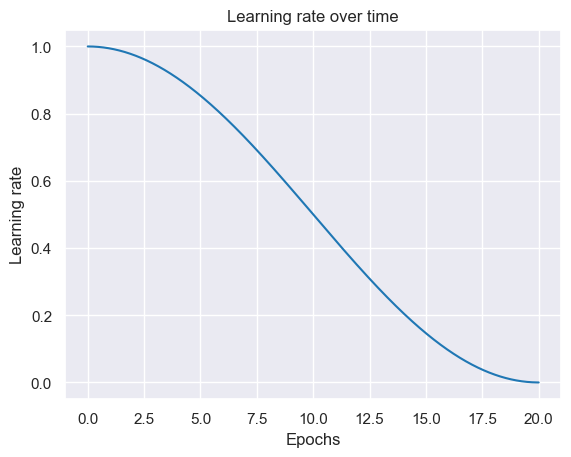

In [504]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot learning rate over time
plt.plot(np.arange(max_iter)/(max_iter/n_epochs), [0.5 * (1 + np.cos(np.pi * t / max_iter)) for t in range(0, max_iter, 1)])
plt.title('Learning rate over time')
plt.xlabel('Epochs')
plt.ylabel('Learning rate')
plt.show()

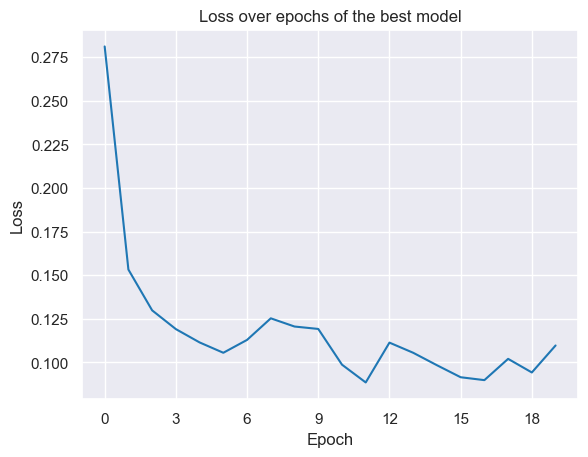

In [505]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

sns.set()
sns.set_style('darkgrid')
sns.set_palette('tab10')

# Calculate loss_history_averaged by averaging over n_epochs batches
n_iter = train_data[0].shape[0]//best_params['batch_size']
loss_history_averaged = [np.mean(best_params['loss_list'][i:i+n_iter]) for i in range(0, len(best_params['loss_list']), n_iter)]
plt.plot(loss_history_averaged)
plt.title('Loss over epochs of the best model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

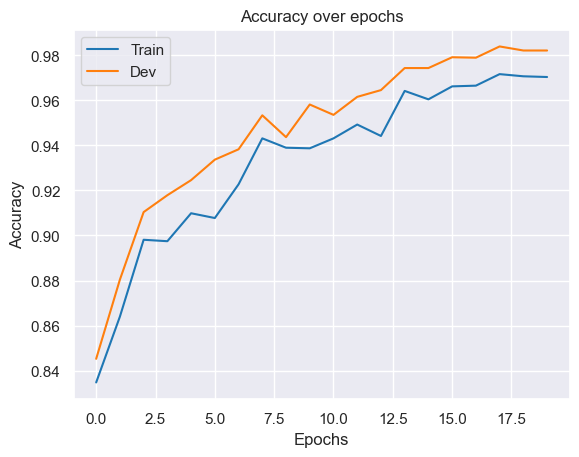

In [506]:
plt.title('Accuracy over epochs')
plt.plot(best_params['train_accs'])
plt.plot(best_params['dev_accs'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Dev'], loc='upper left')
plt.show()

### The effect of learning rate scheduler

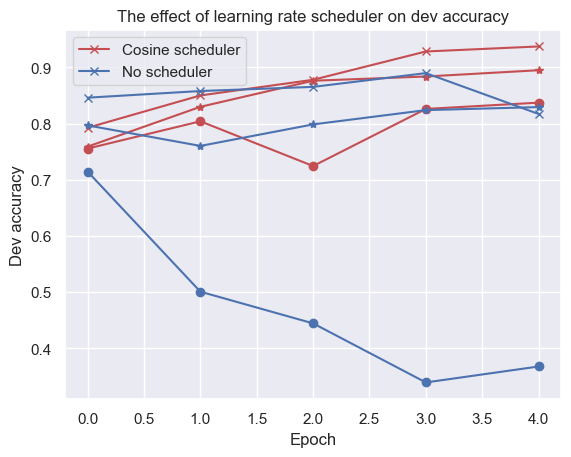

In [29]:
# plot the dev accuracy over time, to show the difference between the two schedulers
# knowing that experiment_{even_numer} is with cosine scheduler and experiment_{odd_number} is with no scheduler

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import pickle

sns.set()
sns.set_style('darkgrid')
sns.set_palette('tab10')

for i in range(0, 6, 2):
    with open(f'./experiment_{i}.pkl', 'rb') as f:
        experiment = pickle.load(f)
        if i == 0:
            symbol = 'o'
        elif i == 2:
            symbol = '*'
        elif i == 4:
            symbol = 'x'
        plt.plot(experiment['dev_accuracy'], 'r-' + symbol, label='Cosine scheduler')

for i in range(1, 6, 2):
    with open(f'./experiment_{i}.pkl', 'rb') as f:
        experiment = pickle.load(f)
        if i-1 == 0:
            symbol = 'o'
        elif i-1 == 2:
            symbol = '*'
        elif i-1 == 4:
            symbol = 'x'
        plt.plot(experiment['dev_accuracy'], 'b-'+ symbol, label='No scheduler')
plt.title('The effect of learning rate scheduler on dev accuracy')
plt.xlabel('Epoch')
plt.ylabel('Dev accuracy')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

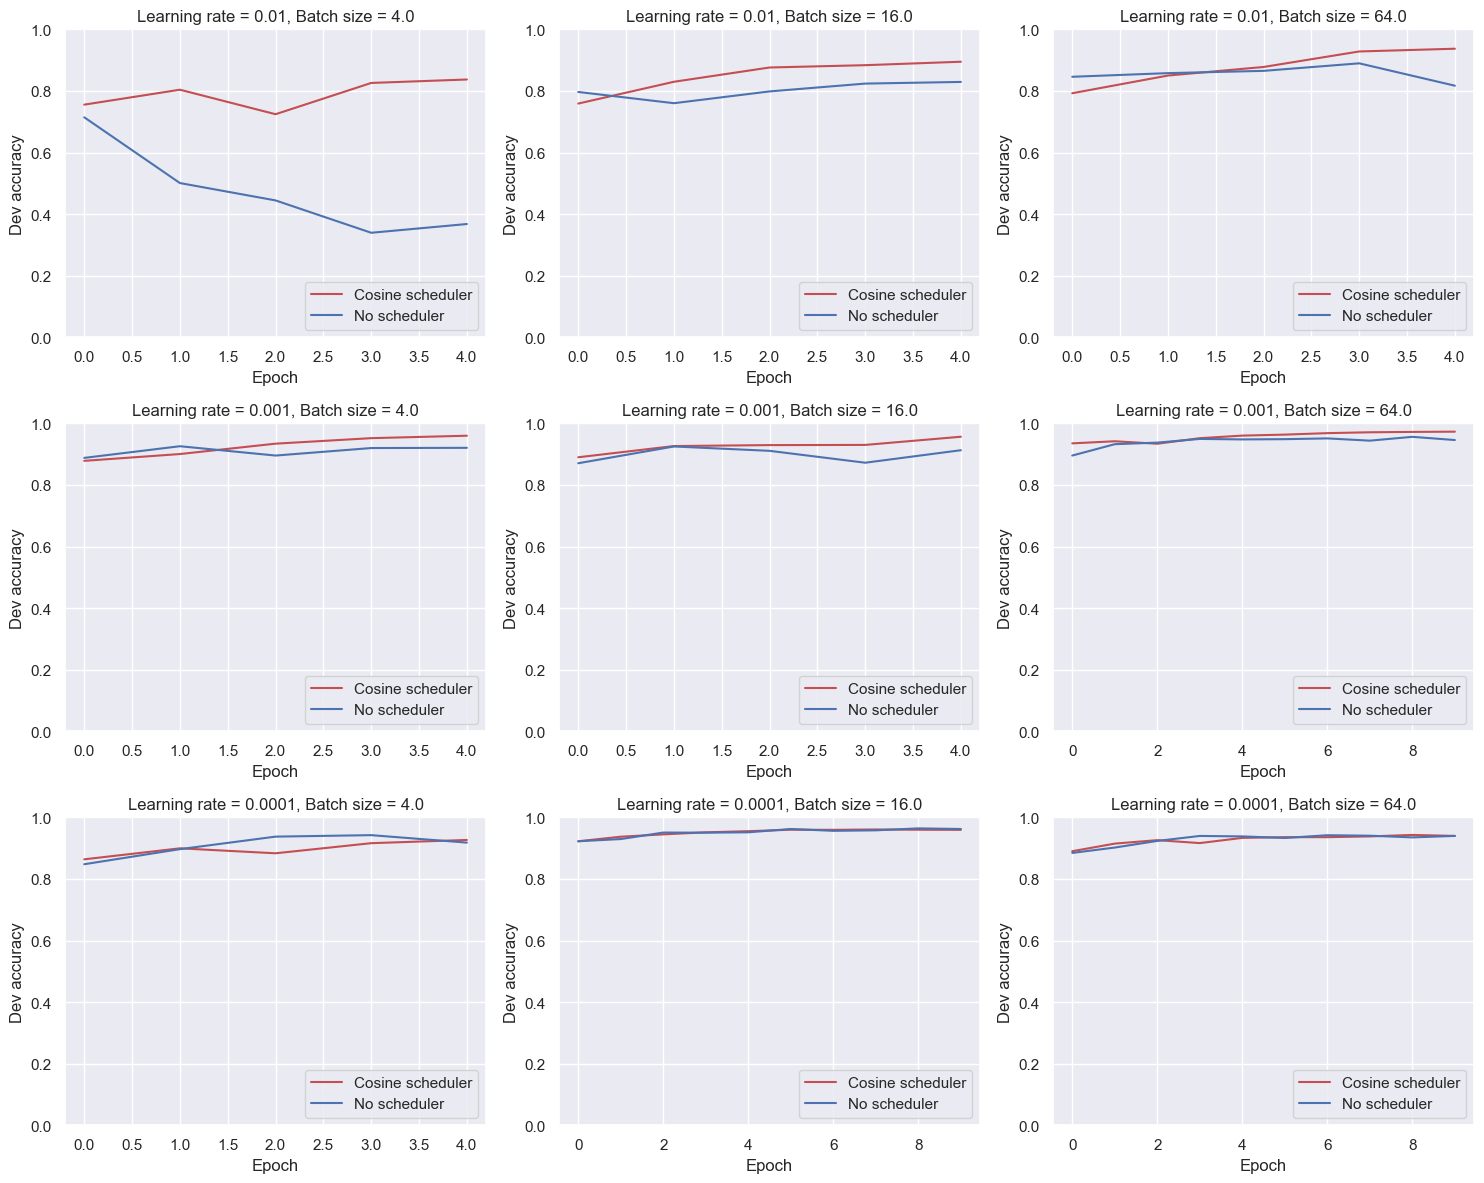

In [53]:
# Instead of plotting in the same plot, we will create 3 subplots, one for each learning rate

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

df = pd.read_csv('experiment.csv')

sns.set()
sns.set_style('darkgrid')
sns.set_palette('tab10')

fig, axs = plt.subplots(3, 3, figsize=(15, 12))
# now plot the dev accuracy over time, to show the difference between the two schedulers
# knowing that experiment_{even_numer} is with cosine scheduler and experiment_{odd_number} is with no scheduler
for j in range(3):
    for i in range(0, 6, 2):
        with open(f'./experiment_{j*20 + i}.pkl', 'rb') as f:
            experiment = pickle.load(f)
            axs[j, i//2].plot(experiment['dev_accuracy'], 'r', label='Cosine scheduler')
            axs[j, i//2].set_ylim([0, 1])
            axs[j, i//2].set_title(f'Learning rate = {df.loc[j*20 + i, "lr"]}, Batch size = {df.loc[i, "batch_size"]}')
            axs[j, i//2].set_xlabel('Epoch')
            axs[j, i//2].set_ylabel('Dev accuracy')
    for i in range(1, 6, 2):
        with open(f'./experiment_{j*20 + i}.pkl', 'rb') as f:
            experiment = pickle.load(f)
            axs[j, i//2].plot(experiment['dev_accuracy'], 'b', label='No scheduler')
            axs[j, i//2].set_ylim([0, 1])
            axs[j, i//2].legend(loc='lower right')


plt.tight_layout()
plt.show()

